In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count, prepare_df

In [3]:
from survival_analysis import prepare_df

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


Individual Sector Parameters:
      mu_ub         mu_lb          K           m
G  0.136600  3.574423e-02  12.391134    4.143563
M  0.108775  4.180960e-02  12.552693    4.413912
F  0.079990  1.000000e-10  26.182377   79.999864
J  0.130908  3.791174e-02  11.942981    4.056575
K  0.070120  1.107103e-02  17.600632   11.719754
C  0.103010  4.128293e-02   9.260455    8.139253
H  0.190144  2.801602e-02   6.937676  100.000000
S  0.140580  1.000000e-10  12.953553    5.189874
N  0.123962  1.000000e-10  16.432767    3.676400
I  0.125687  3.447114e-02  17.442831    5.606094
P  0.121214  6.868425e-02   9.445186  100.000000
L  0.074121  1.000000e-10  25.775318   79.998605
Q  0.078302  4.719794e-02   7.791976  100.000000
R  0.132290  8.548577e-02   8.857323  100.000000
Initializing with k-means clustering...
Initial cluster assignments:
  G: Cluster 0
  M: Cluster 0
  F: Cluster 1
  J: Cluster 0
  K: Cluster 0
  C: Cluster 0
  H: Cluster 1
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 1
 

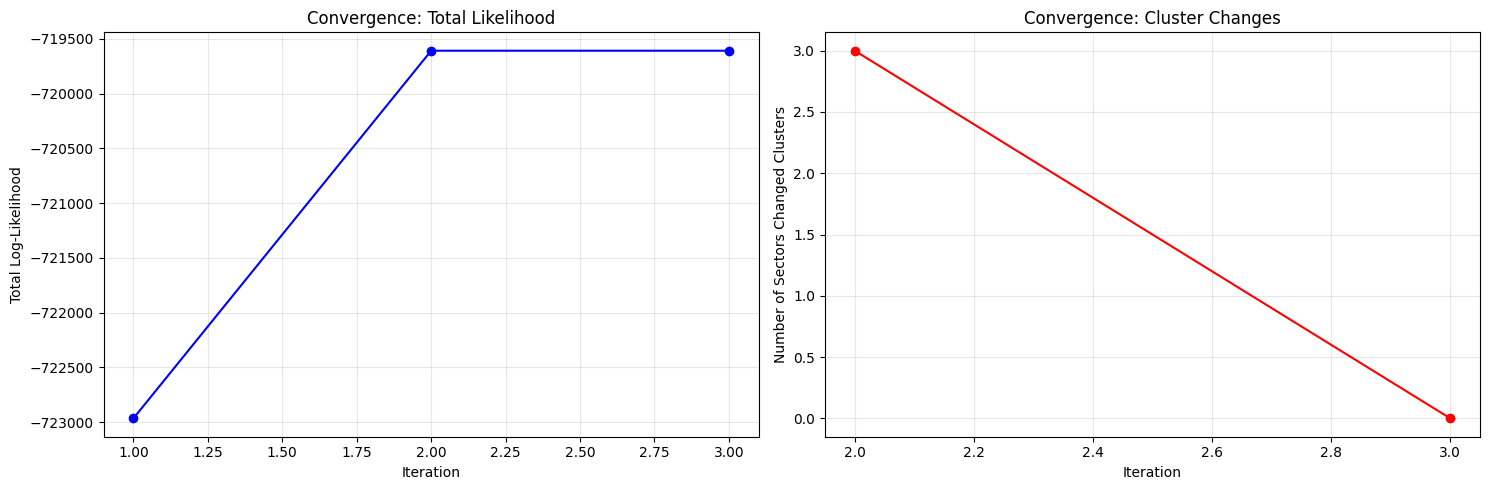

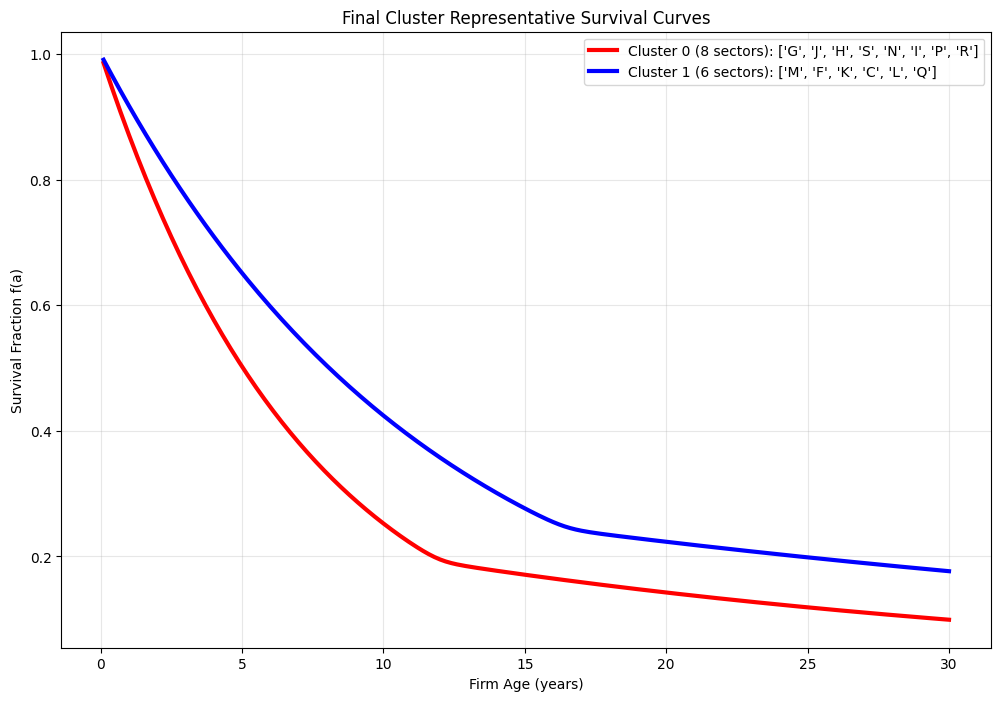

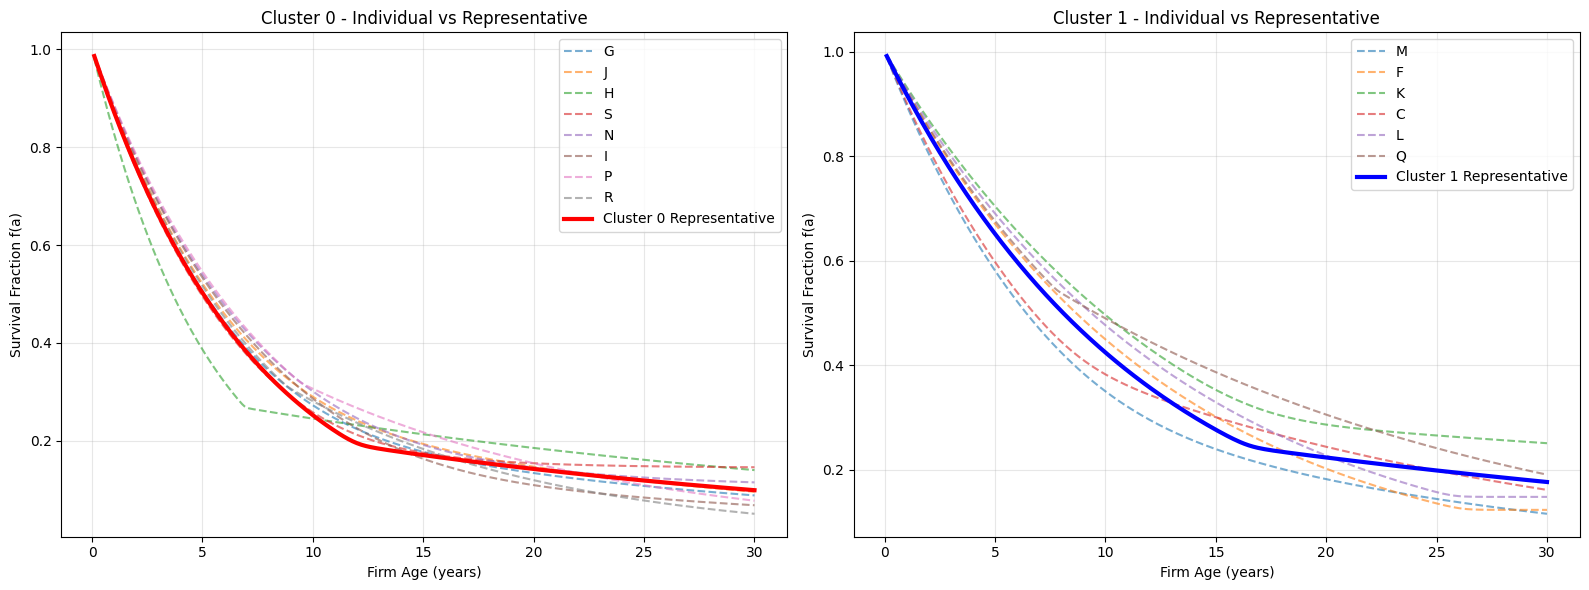

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)


def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])


# # Simulate some f(a) data for each sector (in practice, you'd have real data)
# np.random.seed(42)
# ages_data = np.linspace(0, 30, 60)  # Age points where you have data

# # Generate synthetic f(a) data using the fitted parameters + noise
# survival_data = {}
# for i, sector in enumerate(sector_list):
#     params = parameters[i]
#     true_survival = model_survival_curve_hill(ages_data, *params)
#     # Add some noise to simulate real data
#     noisy_survival = true_survival * (1 + 0.05 * np.random.randn(len(ages_data)))
#     noisy_survival = np.clip(noisy_survival, 0.01, 1.0)  # Keep in valid range
#     survival_data[sector] = noisy_survival

# print(f"\nGenerated survival data for {len(ages_data)} age points per sector")

survival_data = {}
for sector in sector_list:
    survival_data[sector], ages_data = obtain_survival_fractions(df_analysis, 'Sector', sector)


# Log-likelihood function
# def log_likelihood(survival_obs, survival_pred, sigma=0.05):
#     """
#     Compute log-likelihood assuming Gaussian noise
#     """
#     residuals = survival_obs - survival_pred
#     ll = -0.5 * np.sum(residuals**2 / sigma**2) - 0.5 * len(residuals) * np.log(2 * np.pi * sigma**2)
#     return ll

# def compute_sector_likelihood(sector_data, model_params):
#     """
#     Compute likelihood of sector data given model parameters
#     """
#     predicted_survival = model_survival_curve_hill(ages_data, *model_params)
#     return log_likelihood(sector_data, predicted_survival)

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def compute_sector_likelihood(sector, model_params):
    """    
    Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    return log_likelihood(model_params, ages_data, survivors, totals)
    

# Iterative clustering algorithm
def iterative_likelihood_clustering(survival_data, df_params, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print("Initializing with k-means clustering...")
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in [0, 1]:
        mask = initial_clusters == cluster_id
        cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters:")
    for cluster_id, params in cluster_params.items():
        print(f"  Cluster {cluster_id}: {params}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            sector_data = survival_data[sector]
            
            # Compute likelihood for each cluster model
            ll_0 = compute_sector_likelihood(sector, cluster_params[0])
            ll_1 = compute_sector_likelihood(sector, cluster_params[1])
            
            # Assign to cluster with higher likelihood
            if ll_0 > ll_1:
                new_clusters[i] = 0
            else:
                new_clusters[i] = 1
            
            sector_likelihoods[sector] = {'ll_0': ll_0, 'll_1': ll_1, 'assigned': new_clusters[i]}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            print(f"  {sector}: LL_0={lls['ll_0']:.2f}, LL_1={lls['ll_1']:.2f} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters
        new_cluster_params = {}
        for cluster_id in [0, 1]:
            mask = new_clusters == cluster_id
            if np.sum(mask) > 0:  # Check if cluster is non-empty
                new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                # Keep old parameters if cluster becomes empty
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters:")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")
        
        # Check convergence
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        param_change = 0
        for cluster_id in [0, 1]:
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            sector_data = survival_data[sector]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Run the clustering
final_clusters, final_params, history = iterative_likelihood_clustering(survival_data, df_params)

print(f"\n{'='*50}")
print("FINAL RESULTS")
print(f"{'='*50}")

print("\nFinal cluster assignments:")
for i, sector in enumerate(sector_list):
    print(f"  {sector}: Cluster {final_clusters[i]}")

print("\nFinal cluster parameters:")
for cluster_id, params in final_params.items():
    n_sectors = np.sum(final_clusters == cluster_id)
    sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
    print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
    print(f"  mu_ub: {params[0]:.6f}")
    print(f"  mu_lb: {params[1]:.6f}")
    print(f"  K: {params[2]:.6f}")
    print(f"  m: {params[3]:.6f}")

# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot total likelihood over iterations
axes[0].plot(history['iteration'], history['total_likelihood'], 'bo-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Total Log-Likelihood')
axes[0].set_title('Convergence: Total Likelihood')
axes[0].grid(True, alpha=0.3)

# Plot cluster assignments over iterations
cluster_changes = []
for i in range(1, len(history['cluster_assignments'])):
    prev_clusters = history['cluster_assignments'][i-1]
    curr_clusters = history['cluster_assignments'][i]
    n_changes = np.sum(prev_clusters != curr_clusters)
    cluster_changes.append(n_changes)

if cluster_changes:
    axes[1].plot(range(2, len(history['iteration'])+1), cluster_changes, 'ro-')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Number of Sectors Changed Clusters')
    axes[1].set_title('Convergence: Cluster Changes')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot final cluster representative survival curves
ages_plot = np.linspace(0.1, 30, 300)
plt.figure(figsize=(12, 8))

colors = ['red', 'blue']
for cluster_id, params in final_params.items():
    survival_curve = model_survival_curve_hill(ages_plot, *params)
    n_sectors = np.sum(final_clusters == cluster_id)
    sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
    
    plt.plot(ages_plot, survival_curve, color=colors[cluster_id], linewidth=3,
             label=f'Cluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}')

plt.xlabel('Firm Age (years)')
plt.ylabel('Survival Fraction f(a)')
plt.title('Final Cluster Representative Survival Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare with individual sector curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for cluster_id in [0, 1]:
    ax = axes[cluster_id]
    sectors_in_cluster = [i for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
    
    # Plot individual sector curves
    for sector_idx in sectors_in_cluster:
        sector = sector_list[sector_idx]
        individual_curve = model_survival_curve_hill(ages_plot, *parameters[sector_idx])
        ax.plot(ages_plot, individual_curve, '--', alpha=0.6, label=f'{sector}')
    
    # Plot cluster representative
    cluster_curve = model_survival_curve_hill(ages_plot, *final_params[cluster_id])
    ax.plot(ages_plot, cluster_curve, color=colors[cluster_id], linewidth=3, 
            label=f'Cluster {cluster_id} Representative')
    
    ax.set_xlabel('Firm Age (years)')
    ax.set_ylabel('Survival Fraction f(a)')
    ax.set_title(f'Cluster {cluster_id} - Individual vs Representative')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Individual Sector Parameters:
      mu_ub         mu_lb          K           m
G  0.136600  3.574423e-02  12.391134    4.143563
M  0.108775  4.180960e-02  12.552693    4.413912
F  0.079990  1.000000e-10  26.182377   79.999864
J  0.130908  3.791174e-02  11.942981    4.056575
K  0.070120  1.107103e-02  17.600632   11.719754
C  0.103010  4.128293e-02   9.260455    8.139253
H  0.190144  2.801602e-02   6.937676  100.000000
S  0.140580  1.000000e-10  12.953553    5.189874
N  0.123962  1.000000e-10  16.432767    3.676400
I  0.125687  3.447114e-02  17.442831    5.606094
P  0.121214  6.868425e-02   9.445186  100.000000
L  0.074121  1.000000e-10  25.775318   79.998605
Q  0.078302  4.719794e-02   7.791976  100.000000
R  0.132290  8.548577e-02   8.857323  100.000000
Using age bins from 0 to 30.0 years with 150 bins

RUNNING 3-CLUSTER ANALYSIS

Initializing 3-cluster analysis with k-means clustering...
K-means clustering works by:
  1. Randomly placing k cluster centers in the parameter space
  2. 

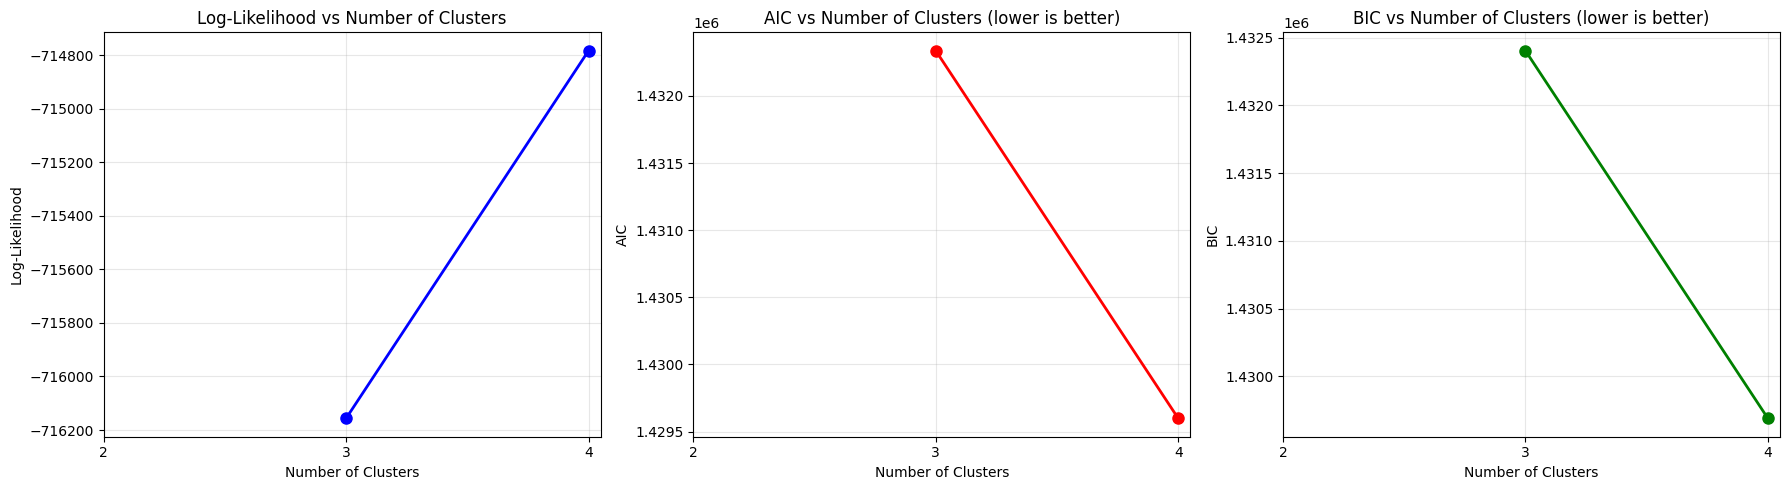

KeyError: 2

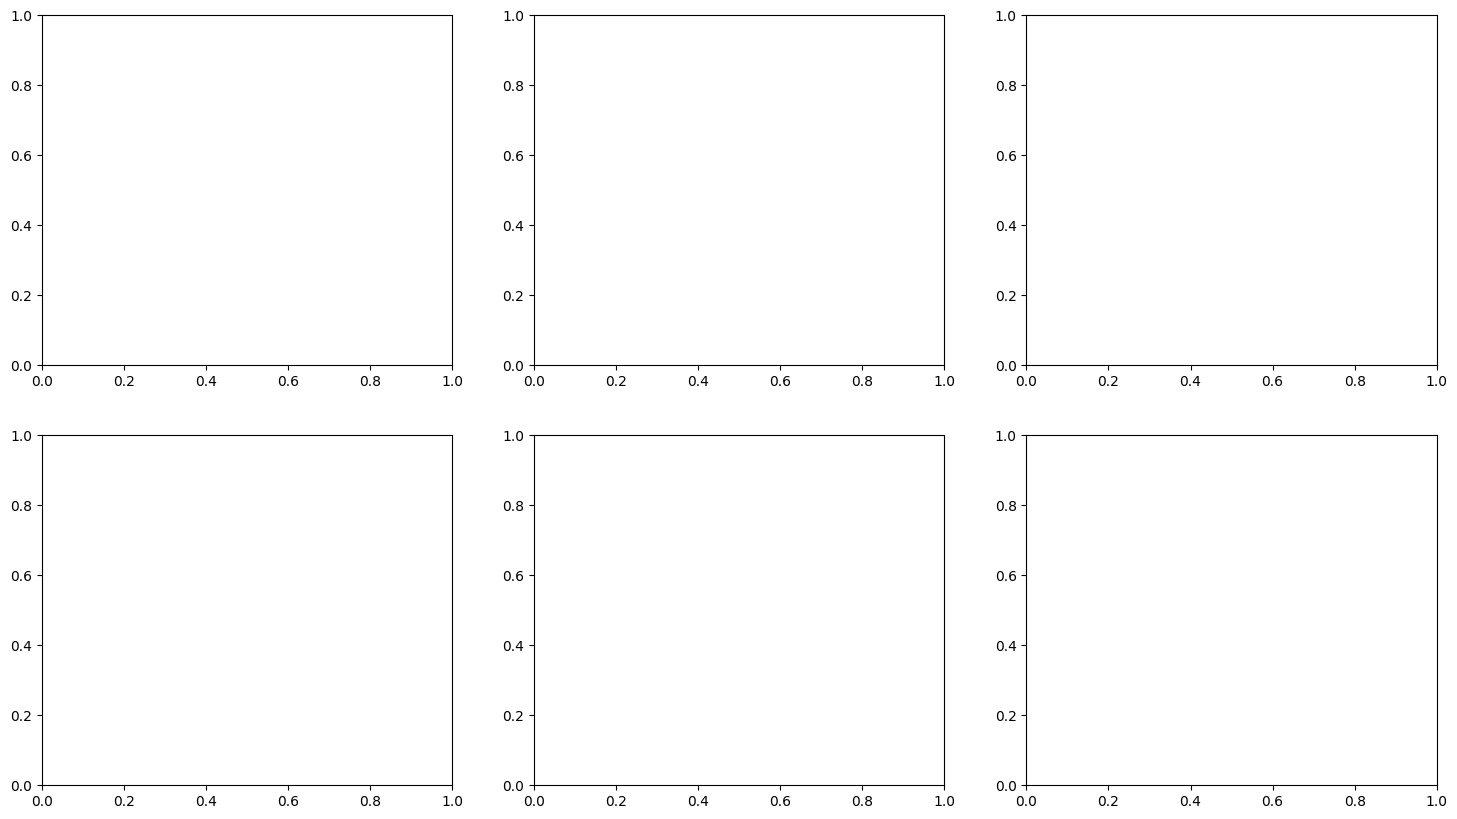

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def reestimate_cluster_params_mle(cluster_sectors):
    """
    CORRECTED: Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Define objective function
    def neg_log_likelihood(params):
        ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
        return -ll if np.isfinite(ll) else 1e10
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    
    # Set reasonable bounds with more relaxed m bounds
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0),     # K
              (0.1, 200.0)]     # m - increased upper bound for more flexibility
    
    # Optimize with multiple attempts
    best_params = initial_guess
    best_ll = -1e10
    
    for attempt in range(3):  # Try multiple starting points
        try:
            if attempt == 0:
                start_params = initial_guess
            else:
                # Add some noise to initial guess for additional attempts
                # Use smaller noise for m parameter to avoid extreme values
                noise = np.random.normal(0, 0.1, size=4)
                noise[3] *= 0.5  # Reduce noise for m parameter
                start_params = np.abs(initial_guess + noise * initial_guess)
                # Ensure bounds are respected
                start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
                start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
                start_params[2] = np.clip(start_params[2], 0.1, 100.0)
                start_params[3] = np.clip(start_params[3], 0.1, 200.0)  # Updated bound
            
            result = minimize(neg_log_likelihood, start_params, 
                            method='L-BFGS-B', bounds=bounds)
            
            if result.success:
                ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
                if ll > best_ll:
                    best_ll = ll
                    best_params = result.x
                    
        except Exception as e:
            print(f"    Optimization attempt {attempt+1} failed: {e}")
            continue
    
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    CORRECTED: Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1, m_tolerance=0.5):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    print("K-means clustering works by:")
    print("  1. Randomly placing k cluster centers in the parameter space")
    print("  2. Assigning each sector to the nearest cluster center (Euclidean distance)")
    print("  3. Moving cluster centers to the mean of assigned sectors")
    print("  4. Repeating steps 2-3 until convergence")
    print("  This provides good initial cluster assignments based on parameter similarity")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters:")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): {params}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters:")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")
        
        # Check convergence with weighted parameter changes
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Calculate weighted parameter change - give less weight to m parameter
        param_change = 0
        param_weights = [1.0, 1.0, 1.0, 0.02]  # Less weight on m parameter (index 3)
        
        for cluster_id in range(n_clusters):
            old_params = cluster_params[cluster_id]
            new_params = new_cluster_params[cluster_id]
            
            # Weighted sum of squared differences
            weighted_diff = np.sum([(new_params[i] - old_params[i])**2 * param_weights[i] 
                                  for i in range(4)])
            param_change += weighted_diff
        
        # Also check relative changes for m parameter specifically
        max_m_relative_change = 0
        for cluster_id in range(n_clusters):
            old_m = cluster_params[cluster_id][3]
            new_m = new_cluster_params[cluster_id][3]
            if old_m > 0:
                m_relative_change = abs(new_m - old_m) / old_m
                max_m_relative_change = max(max_m_relative_change, m_relative_change)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Weighted parameter change: {param_change:.6f}")
        print(f"  Max relative m change: {max_m_relative_change:.3f}")
        
        # More tolerant convergence criteria
        m_tolerance = 0.5  # Allow 50% relative change in m parameter
        if (not clusters_changed and 
            param_change < tolerance and 
            max_m_relative_change < m_tolerance):
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 4 parameters per cluster
    n_params = n_clusters * 4
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# Run clustering for k = 2, 3, 4
results = {}
model_comparison = {}

for k in [3, 4]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters:")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: {params[3]:.6f}")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Log-likelihood
axes[0].plot(comparison_df.index, comparison_df['log_likelihood'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Log-Likelihood vs Number of Clusters')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([2, 3, 4])

# AIC
axes[1].plot(comparison_df.index, comparison_df['AIC'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC vs Number of Clusters (lower is better)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks([2, 3, 4])

# BIC
axes[2].plot(comparison_df.index, comparison_df['BIC'], 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('BIC')
axes[2].set_title('BIC vs Number of Clusters (lower is better)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks([2, 3, 4])

plt.tight_layout()
plt.show()

# Plot convergence for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

colors = ['blue', 'red', 'green']
cluster_labels = [2, 3, 4]

for idx, k in enumerate([3, 4]):
    history = results[k]['history']
    
    # Total likelihood over iterations
    axes[0, idx].plot(history['iteration'], history['total_likelihood'], 
                     'o-', color=colors[idx], linewidth=2, markersize=6)
    axes[0, idx].set_xlabel('Iteration')
    axes[0, idx].set_ylabel('Total Log-Likelihood')
    axes[0, idx].set_title(f'{k} Clusters: Likelihood Convergence')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Cluster changes over iterations
    cluster_changes = []
    for i in range(1, len(history['cluster_assignments'])):
        prev_clusters = history['cluster_assignments'][i-1]
        curr_clusters = history['cluster_assignments'][i]
        n_changes = np.sum(prev_clusters != curr_clusters)
        cluster_changes.append(n_changes)
    
    if cluster_changes:
        axes[1, idx].plot(range(2, len(history['iteration'])+1), cluster_changes, 
                         'o-', color=colors[idx], linewidth=2, markersize=6)
        axes[1, idx].set_xlabel('Iteration')
        axes[1, idx].set_ylabel('Number of Sectors Changed Clusters')
        axes[1, idx].set_title(f'{k} Clusters: Assignment Changes')
        axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot representative survival curves for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ages_plot = np.linspace(0.1, 30, 300)
colors_list = [['red', 'blue'], 
               ['red', 'blue', 'green'], 
               ['red', 'blue', 'green', 'orange']]

for idx, k in enumerate([2, 3, 4]):
    ax = axes[idx]
    final_clusters = results[k]['clusters']
    final_params = results[k]['params']
    colors = colors_list[idx]
    
    for cluster_id, params in final_params.items():
        survival_curve = model_survival_curve_hill(ages_plot, *params)
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        
        ax.plot(ages_plot, survival_curve, color=colors[cluster_id], linewidth=3,
                label=f'Cluster {cluster_id} ({n_sectors}): {sectors_in_cluster}')
    
    ax.set_xlabel('Firm Age (years)')
    ax.set_ylabel('Survival Fraction f(a)')
    ax.set_title(f'{k} Clusters: Representative Survival Curves')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed comparison table
print(f"\n{'='*60}")
print("DETAILED CLUSTER ASSIGNMENTS COMPARISON")
print(f"{'='*60}")

assignment_comparison = pd.DataFrame({
    '2_clusters': results[2]['clusters'],
    '3_clusters': results[3]['clusters'],
    '4_clusters': results[4]['clusters']
}, index=sector_list)

print(assignment_comparison)

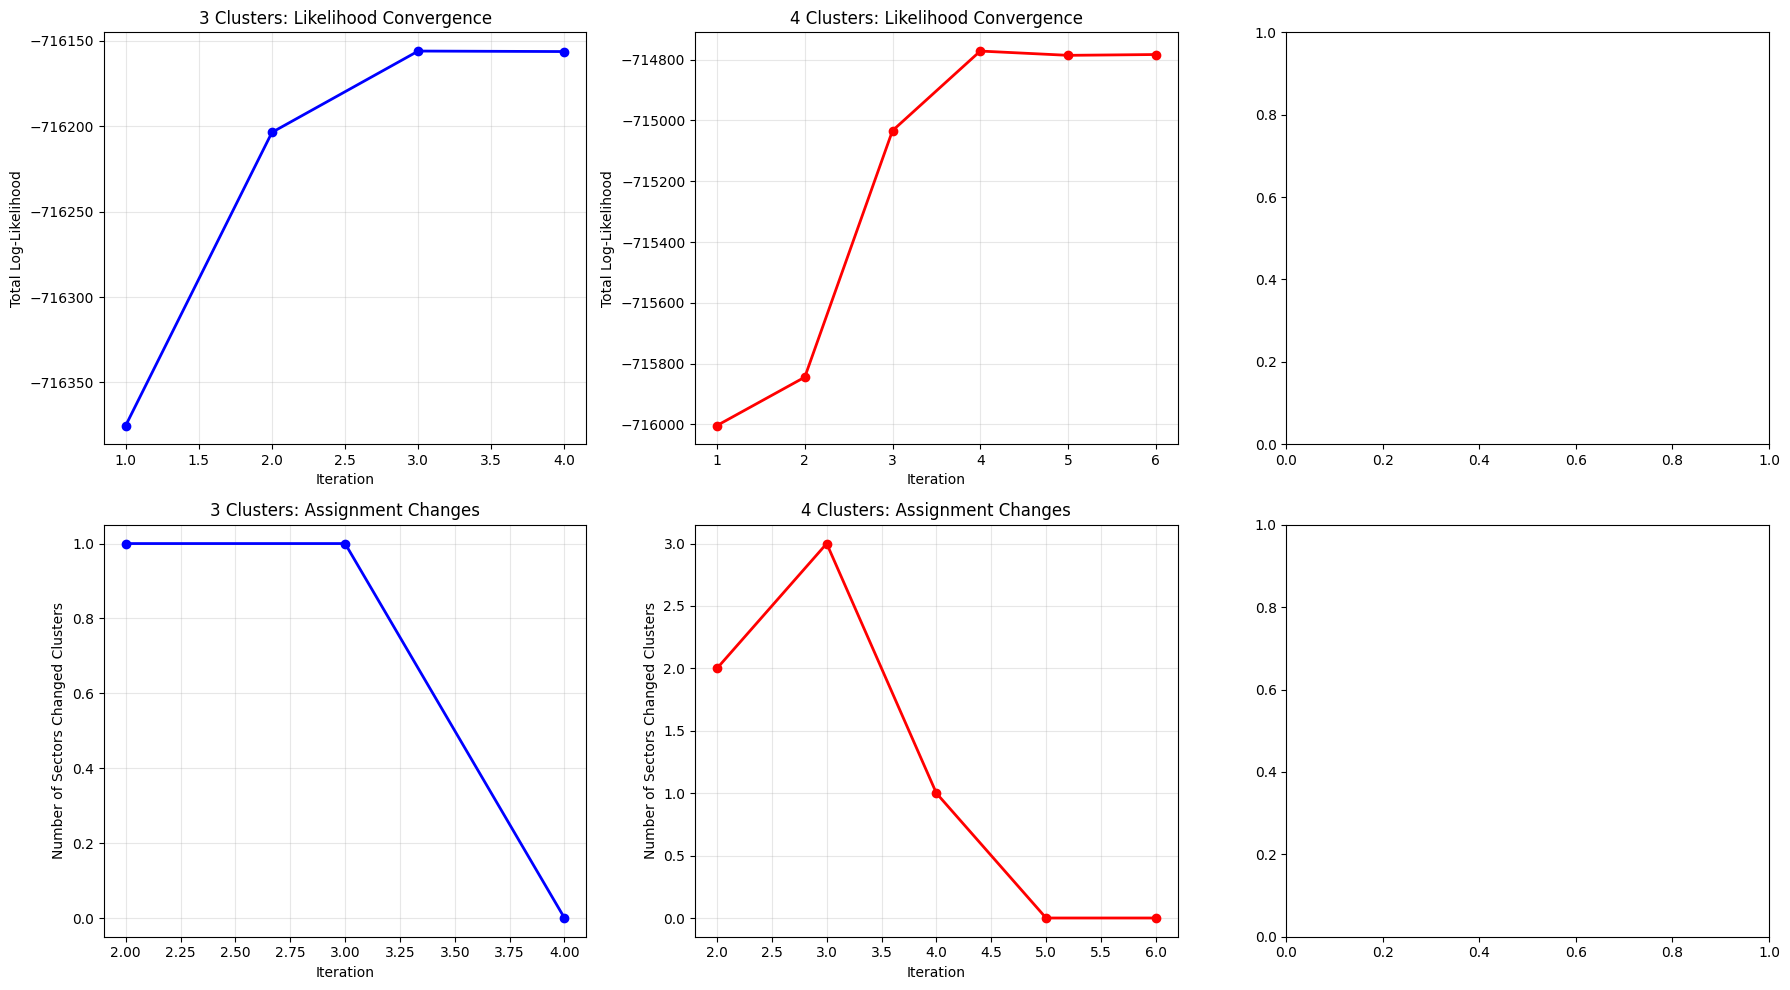

IndexError: list index out of range

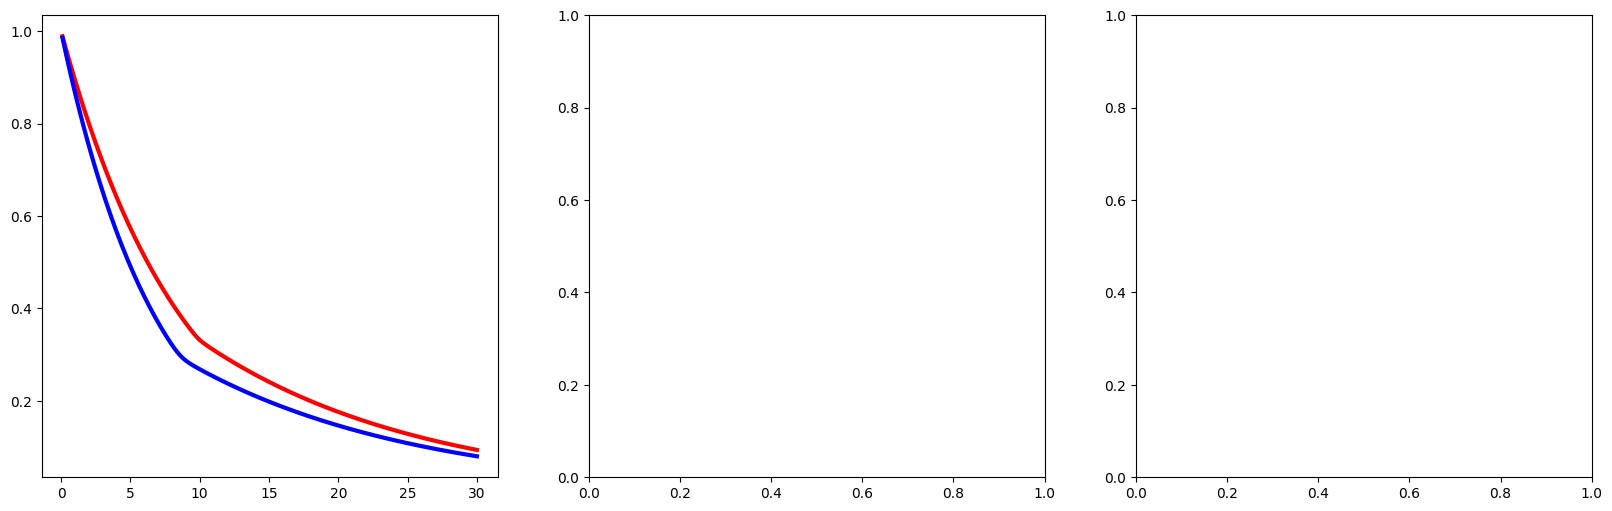

In [12]:
# Plot convergence for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

colors = ['blue', 'red', 'green']
cluster_labels = [2, 3, 4]

for idx, k in enumerate([3, 4]):
    history = results[k]['history']
    
    # Total likelihood over iterations
    axes[0, idx].plot(history['iteration'], history['total_likelihood'], 
                     'o-', color=colors[idx], linewidth=2, markersize=6)
    axes[0, idx].set_xlabel('Iteration')
    axes[0, idx].set_ylabel('Total Log-Likelihood')
    axes[0, idx].set_title(f'{k} Clusters: Likelihood Convergence')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Cluster changes over iterations
    cluster_changes = []
    for i in range(1, len(history['cluster_assignments'])):
        prev_clusters = history['cluster_assignments'][i-1]
        curr_clusters = history['cluster_assignments'][i]
        n_changes = np.sum(prev_clusters != curr_clusters)
        cluster_changes.append(n_changes)
    
    if cluster_changes:
        axes[1, idx].plot(range(2, len(history['iteration'])+1), cluster_changes, 
                         'o-', color=colors[idx], linewidth=2, markersize=6)
        axes[1, idx].set_xlabel('Iteration')
        axes[1, idx].set_ylabel('Number of Sectors Changed Clusters')
        axes[1, idx].set_title(f'{k} Clusters: Assignment Changes')
        axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot representative survival curves for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ages_plot = np.linspace(0.1, 30, 300)
colors_list = [['red', 'blue'], 
               ['red', 'blue', 'green'], 
               ['red', 'blue', 'green', 'orange']]

for idx, k in enumerate([3, 4]):
    ax = axes[idx]
    final_clusters = results[k]['clusters']
    final_params = results[k]['params']
    colors = colors_list[idx]
    
    for cluster_id, params in final_params.items():
        survival_curve = model_survival_curve_hill(ages_plot, *params)
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        
        ax.plot(ages_plot, survival_curve, color=colors[cluster_id], linewidth=3,
                label=f'Cluster {cluster_id} ({n_sectors}): {sectors_in_cluster}')
    
    ax.set_xlabel('Firm Age (years)')
    ax.set_ylabel('Survival Fraction f(a)')
    ax.set_title(f'{k} Clusters: Representative Survival Curves')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed comparison table
print(f"\n{'='*60}")
print("DETAILED CLUSTER ASSIGNMENTS COMPARISON")
print(f"{'='*60}")

assignment_comparison = pd.DataFrame({
    '2_clusters': results[2]['clusters'],
    '3_clusters': results[3]['clusters'],
    '4_clusters': results[4]['clusters']
}, index=sector_list)

print(assignment_comparison)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

# Hill function with fixed m=5
def hill3k_hazard(a, mu_ub, mu_lb, K):
    return mu_ub - (mu_ub - mu_lb) * (a**5) / (a**5 + K**5 + 1e-10)  # m=5 fixed

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)
    return np.exp(-result)

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    return np.array([hill3k_survival_function(a, mu_ub, mu_lb, K) for a in ages])

# # Legacy functions for backward compatibility (redirect to 3k versions)
# def hill_hazard(a, mu_ub, mu_lb, K, m=5):
#     return hill3k_hazard(a, mu_ub, mu_lb, K)

# def hill_survival_function(a, mu_ub, mu_lb, K, m=5):
#     return hill3k_survival_function(a, mu_ub, mu_lb, K)

# def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m=5):
#     return model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params  # Only 3 parameters now
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    return -log_likelihood(params, ages, survivors, totals)

def reestimate_cluster_params_mle(cluster_sectors):
    """
    CORRECTED: Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)

    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Define objective function
    def neg_log_likelihood(params):
        ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
        return -ll if np.isfinite(ll) else 1e10
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    
    # Set reasonable bounds for 3 parameters
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0)]     # K
    
    # Optimize with multiple attempts
    best_params = initial_guess
    best_ll = -1e10
    
    for attempt in range(3):  # Try multiple starting points
        try:
            if attempt == 0:
                start_params = initial_guess
            else:
                # Add some noise to initial guess for additional attempts (3 parameters)
                noise = np.random.normal(0, 0.1, size=3)
                start_params = np.abs(initial_guess + noise * initial_guess)
                # Ensure bounds are respected
                start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
                start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
                start_params[2] = np.clip(start_params[2], 0.1, 100.0)
            
            result = minimize(neg_log_likelihood, start_params, 
                            method='L-BFGS-B', bounds=bounds)
            
            if result.success:
                ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
                if ll > best_ll:
                    best_ll = ll
                    best_params = result.x
                    
        except Exception as e:
            print(f"    Optimization attempt {attempt+1} failed: {e}")
            continue
    
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    CORRECTED: Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    print("K-means clustering works by:")
    print("  1. Randomly placing k cluster centers in the parameter space")
    print("  2. Assigning each sector to the nearest cluster center (Euclidean distance)")
    print("  3. Moving cluster centers to the mean of assigned sectors")
    print("  4. Repeating steps 2-3 until convergence")
    print("  This provides good initial cluster assignments based on parameter similarity")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters (m=5 fixed):")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters (m=5 fixed):")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
        
        # Check convergence - simplified for 3 parameters
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Standard parameter change calculation
        param_change = 0
        for cluster_id in range(n_clusters):
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 3 parameters per cluster (m fixed at 5)
    n_params = n_clusters * 3
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# Run clustering for k = 2, 3, 4
results = {}
model_comparison = {}

for k in [2, 3, 4]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters (m=5 fixed):")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: 5.0 (fixed)")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Visualization code remains the same...
# [Rest of plotting code would go here]

Individual Sector Parameters:
      mu_ub         mu_lb          K
G  0.136600  3.574423e-02  12.391134
M  0.108775  4.180960e-02  12.552693
F  0.079990  1.000000e-10  26.182377
J  0.130908  3.791174e-02  11.942981
K  0.070120  1.107103e-02  17.600632
C  0.103010  4.128293e-02   9.260455
H  0.190144  2.801602e-02   6.937676
S  0.140580  1.000000e-10  12.953553
N  0.123962  1.000000e-10  16.432767
I  0.125687  3.447114e-02  17.442831
P  0.121214  6.868425e-02   9.445186
L  0.074121  1.000000e-10  25.775318
Q  0.078302  4.719794e-02   7.791976
R  0.132290  8.548577e-02   8.857323
Using age bins from 0 to 30.0 years with 150 bins

RUNNING 2-CLUSTER ANALYSIS

Initializing 2-cluster analysis with k-means clustering...
K-means clustering works by:
  1. Randomly placing k cluster centers in the parameter space
  2. Assigning each sector to the nearest cluster center (Euclidean distance)
  3. Moving cluster centers to the mean of assigned sectors
  4. Repeating steps 2-3 until convergence
  Th

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(
C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


Updated cluster parameters (m=5 fixed):
  Cluster 0 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Cluster 1 (6 sectors): mu_ub=0.0908, mu_lb=0.0489, K=12.3748
  Clusters changed: True
  Parameter change: 69.102667

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-198418.30, LL_1=-209895.24 → Cluster 0
  M: LL_0=-108772.93, LL_1=-108076.10 → Cluster 1
  F: LL_0=-50751.57, LL_1=-47978.08 → Cluster 1
  J: LL_0=-57047.42, LL_1=-59375.50 → Cluster 0
  K: LL_0=-64297.81, LL_1=-57491.47 → Cluster 1
  C: LL_0=-41529.66, LL_1=-39617.01 → Cluster 1
  H: LL_0=-44396.17, LL_1=-48828.65 → Cluster 0
  S: LL_0=-35845.03, LL_1=-37840.37 → Cluster 0
  N: LL_0=-37113.16, LL_1=-38389.83 → Cluster 0
  I: LL_0=-34396.12, LL_1=-36323.80 → Cluster 0
  P: LL_0=-25294.91, LL_1=-25918.96 → Cluster 0
  L: LL_0=-13006.84, LL_1=-12022.25 → Cluster 1
  Q: LL_0=-14564.85, LL_1=-13139.91 → Cluster 1
  R: LL_0=-7553.78, LL_1=-8012.61 → Cluster 0


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(
C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


Updated cluster parameters (m=5 fixed):
  Cluster 0 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Cluster 1 (6 sectors): mu_ub=0.0908, mu_lb=0.0489, K=12.3746
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

2-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -718389.70
AIC: 1436791.39
BIC: 1436825.29

Final cluster assignments:
  G: Cluster 0
  M: Cluster 1
  F: Cluster 1
  J: Cluster 0
  K: Cluster 1
  C: Cluster 1
  H: Cluster 0
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 0
  L: Cluster 1
  Q: Cluster 1
  R: Cluster 0

Final cluster parameters (m=5 fixed):

Cluster 0 (8 sectors): ['G', 'J', 'H', 'S', 'N', 'I', 'P', 'R']
  mu_ub: 0.139926
  mu_lb: 0.047718
  K: 10.127022
  m: 5.0 (fixed)

Cluster 1 (6 sectors): ['M', 'F', 'K', 'C', 'L', 'Q']
  mu_ub: 0.090812
  mu_lb: 0.048873
  K: 12.374642
  m: 5.0 (fixed)

RUNNING 3-CLUSTER ANALYSIS

Initializing 3-cluster analysis with k-means clustering...
K-means clustering works by:
  1. Randomly placing k

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(
C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


Updated cluster parameters (m=5 fixed):
  Cluster 0 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5515
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Clusters changed: True
  Parameter change: 171.314136

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-198418.30, LL_1=-201962.01, LL_2=-217863.28 → Cluster 0
  M: LL_0=-108772.93, LL_1=-106907.52, LL_2=-110302.95 → Cluster 1
  F: LL_0=-50751.57, LL_1=-48615.42, LL_2=-48022.44 → Cluster 2
  J: LL_0=-57047.42, LL_1=-57589.41, LL_2=-61426.54 → Cluster 0
  K: LL_0=-64297.81, LL_1=-59749.79, LL_2=-56673.38 → Cluster 2
  C: LL_0=-41529.66, LL_1=-40078.37, LL_2=-39810.19 → Cluster 2
  H: LL_0=-44396.17, LL_1=-46444.98, LL_2=-51344.93 → Cluster 0
  S: LL_0=-35845.03, LL_1=-36469.14, LL_2=-39297.36 → Cluster 0
  N: LL_0=-37113.16, LL_1=-37295.07, LL_2=-39615.17 → Cluster 0
  I: LL_0=-34396.12, LL_1=-34937.75, LL_2=-37714.38 → Cluster 0
  P: LL_0=-25294.9

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(
C:\Users\chong\AppData\Local\Temp\ipykernel_18100\748830757.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Cluster 1 (2 sectors): mu_ub=0.1106, mu_lb=0.0491, K=12.1421
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7311
  Clusters changed: True
  Parameter change: 0.168207

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-198421.87, LL_1=-201291.94, LL_2=-217863.30 → Cluster 0
  M: LL_0=-108899.21, LL_1=-106925.37, LL_2=-110302.96 → Cluster 1
  F: LL_0=-50844.12, LL_1=-48754.19, LL_2=-48022.45 → Cluster 2
  J: LL_0=-57065.28, LL_1=-57451.29, LL_2=-61426.58 → Cluster 0
  K: LL_0=-64473.71, LL_1=-60124.03, LL_2=-56673.37 → Cluster 2
  C: LL_0=-41581.68, LL_1=-40199.68, LL_2=-39810.20 → Cluster 2
  H: LL_0=-44347.85, LL_1=-46205.74, LL_2=-51345.04 → Cluster 0
  S: LL_0=-35840.72, LL_1=-36366.45, LL_2=-39297.35 → Cluster 0
  N: LL_0=-37127.56, LL_1=-37222.60, LL_2=-39615.16 → Cluster 0
  I: LL_0=-34403.50, LL_1=-34821.09, LL_2=-37714.37 → Cluster 0
  P: LL_0=-25311.74,

KeyboardInterrupt: 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

# Hill function with fixed m=5 - IMPROVED VERSION
def hill3k_hazard(a, mu_ub, mu_lb, K):
    """
    Improved Hill hazard function with better numerical stability
    """
    # Add small epsilon to avoid exactly zero age
    a = max(a, 1e-8)
    
    # Compute a^5 and K^5
    a5 = a**5
    K5 = K**5
    
    # Avoid division by zero and numerical overflow
    denominator = a5 + K5 + 1e-10
    
    # Compute hazard with bounds checking
    hazard = mu_ub - (mu_ub - mu_lb) * a5 / denominator
    
    # Ensure hazard is non-negative and finite
    hazard = max(0, min(hazard, 10.0))  # Cap hazard at reasonable value
    
    return hazard

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    """
    Improved survival function with better integration handling
    """
    if a <= 0:
        return 1.0
    
    try:
        # Use more robust integration with better error handling
        result, error = quad(
            lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 
            0, a,
            limit=100,          # Increase subdivision limit
            epsabs=1e-8,        # Absolute error tolerance
            epsrel=1e-6         # Relative error tolerance
        )
        
        # Check for integration issues
        if not np.isfinite(result):
            print(f"Warning: Non-finite integral result for a={a}, params=({mu_ub}, {mu_lb}, {K})")
            result = 10.0  # Use large value to give survival ≈ 0
            
        # Prevent numerical overflow in exp
        result = min(result, 50.0)  # Cap to prevent exp overflow
        
        survival = np.exp(-result)
        return max(1e-12, min(1.0, survival))  # Ensure valid probability
        
    except Exception as e:
        print(f"Integration failed for a={a}, params=({mu_ub}, {mu_lb}, {K}): {e}")
        # Return reasonable fallback based on age
        return max(1e-12, np.exp(-a * mu_ub))

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    """
    Vectorized survival curve with error handling
    """
    # Check parameter validity
    if mu_ub <= 0 or mu_lb < 0 or K <= 0 or mu_ub < mu_lb:
        print(f"Warning: Invalid parameters - mu_ub={mu_ub}, mu_lb={mu_lb}, K={K}")
        # Return exponential decay as fallback
        return np.exp(-np.array(ages) * max(mu_ub, 0.01))
    
    survival_values = []
    for a in ages:
        try:
            s_val = hill3k_survival_function(a, mu_ub, mu_lb, K)
            survival_values.append(s_val)
        except Exception as e:
            print(f"Error computing survival at age {a}: {e}")
            survival_values.append(np.exp(-a * mu_ub))  # Fallback
    
    return np.array(survival_values)

# Enhanced debugging version
def debug_hill_function(mu_ub, mu_lb, K, max_age=30):
    """
    Debug function to test Hill function behavior
    """
    print(f"\nDebugging Hill function with params: mu_ub={mu_ub:.6f}, mu_lb={mu_lb:.6f}, K={K:.6f}")
    
    # Test hazard at different ages
    test_ages = [0.1, 1, 5, 10, 20, 30]
    print("Hazard values:")
    for age in test_ages:
        try:
            hazard = hill3k_hazard(age, mu_ub, mu_lb, K)
            print(f"  Age {age:2d}: {hazard:.6f}")
        except Exception as e:
            print(f"  Age {age:2d}: ERROR - {e}")
    
    # Test survival at different ages
    print("Survival values:")
    for age in test_ages:
        try:
            survival = hill3k_survival_function(age, mu_ub, mu_lb, K)
            print(f"  Age {age:2d}: {survival:.6f}")
        except Exception as e:
            print(f"  Age {age:2d}: ERROR - {e}")
    
    return True

# Legacy functions for backward compatibility (redirect to 3k versions)
def hill_hazard(a, mu_ub, mu_lb, K, m=5):
    return hill3k_hazard(a, mu_ub, mu_lb, K)

def hill_survival_function(a, mu_ub, mu_lb, K, m=5):
    return hill3k_survival_function(a, mu_ub, mu_lb, K)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m=5):
    return model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params  # Only 3 parameters now
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    return -log_likelihood(params, ages, survivors, totals)

def reestimate_cluster_params_mle(cluster_sectors):
    """
    CORRECTED: Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    print(f"    Re-estimating parameters for sectors: {cluster_sectors}")
    
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    print(f"    Initial guess: mu_ub={initial_guess[0]:.4f}, mu_lb={initial_guess[1]:.4f}, K={initial_guess[2]:.4f}")
    
    # Debug the initial parameters
    try:
        debug_hill_function(initial_guess[0], initial_guess[1], initial_guess[2])
    except:
        print("    Debug function failed, continuing with optimization...")
    
    # Define objective function with better error handling
    def neg_log_likelihood(params):
        try:
            ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
            if not np.isfinite(ll):
                return 1e10
            return -ll
        except Exception as e:
            print(f"    Likelihood computation failed: {e}")
            return 1e10
    
    # Set reasonable bounds for 3 parameters
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0)]     # K
    
    # Optimize with multiple attempts
    best_params = initial_guess
    best_ll = -1e10
    
    for attempt in range(3):  # Try multiple starting points
        try:
            if attempt == 0:
                start_params = initial_guess
            else:
                # Add some noise to initial guess for additional attempts (3 parameters)
                noise = np.random.normal(0, 0.05, size=3)  # Reduced noise
                start_params = np.abs(initial_guess + noise * initial_guess)
                # Ensure bounds are respected
                start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
                start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
                start_params[2] = np.clip(start_params[2], 0.1, 100.0)
            
            print(f"    Attempt {attempt+1}: Starting with {start_params}")
            
            result = minimize(neg_log_likelihood, start_params, 
                            method='L-BFGS-B', bounds=bounds,
                            options={'maxiter': 100})
            
            if result.success:
                ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
                print(f"    Attempt {attempt+1}: Success, LL={ll:.2f}")
                if ll > best_ll:
                    best_ll = ll
                    best_params = result.x
            else:
                print(f"    Attempt {attempt+1}: Failed - {result.message}")
                    
        except Exception as e:
            print(f"    Optimization attempt {attempt+1} failed: {e}")
            continue
    
    print(f"    Final parameters: mu_ub={best_params[0]:.4f}, mu_lb={best_params[1]:.4f}, K={best_params[2]:.4f}")
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    CORRECTED: Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    print("K-means clustering works by:")
    print("  1. Randomly placing k cluster centers in the parameter space")
    print("  2. Assigning each sector to the nearest cluster center (Euclidean distance)")
    print("  3. Moving cluster centers to the mean of assigned sectors")
    print("  4. Repeating steps 2-3 until convergence")
    print("  This provides good initial cluster assignments based on parameter similarity")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters (m=5 fixed):")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters (m=5 fixed):")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
        
        # Check convergence - simplified for 3 parameters
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Standard parameter change calculation
        param_change = 0
        for cluster_id in range(n_clusters):
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 3 parameters per cluster (m fixed at 5)
    n_params = n_clusters * 3
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# Test the Hill function with current parameters before running clustering
print("\n" + "="*60)
print("TESTING HILL FUNCTION WITH CURRENT PARAMETERS")
print("="*60)

# Test a few problematic parameter combinations
test_params = [
    [0.1269, 0.0429, 10.2370],  # Cluster 0 initial
    [0.0948, 0.0091, 20.6868],  # Cluster 1 initial
    [0.1399, 0.0477, 10.1270],  # Cluster 0 updated
    [0.0908, 0.0489, 12.3752],  # Cluster 1 updated
]

for i, params in enumerate(test_params):
    print(f"\nTesting parameter set {i+1}: {params}")
    try:
        debug_hill_function(params[0], params[1], params[2])
    except Exception as e:
        print(f"Failed to test parameters {params}: {e}")

print("\n" + "="*60)
print("STARTING CLUSTERING ANALYSIS")
print("="*60)
results = {}
model_comparison = {}

for k in [2, 3, 4]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters (m=5 fixed):")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: 5.0 (fixed)")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Visualization code remains the same...
# [Rest of plotting code would go here]

Individual Sector Parameters:
      mu_ub         mu_lb          K
G  0.136600  3.574423e-02  12.391134
M  0.108775  4.180960e-02  12.552693
F  0.079990  1.000000e-10  26.182377
J  0.130908  3.791174e-02  11.942981
K  0.070120  1.107103e-02  17.600632
C  0.103010  4.128293e-02   9.260455
H  0.190144  2.801602e-02   6.937676
S  0.140580  1.000000e-10  12.953553
N  0.123962  1.000000e-10  16.432767
I  0.125687  3.447114e-02  17.442831
P  0.121214  6.868425e-02   9.445186
L  0.074121  1.000000e-10  25.775318
Q  0.078302  4.719794e-02   7.791976
R  0.132290  8.548577e-02   8.857323
Using age bins from 0 to 30.0 years with 150 bins

TESTING HILL FUNCTION WITH CURRENT PARAMETERS

Testing parameter set 1: [0.1269, 0.0429, 10.237]

Debugging Hill function with params: mu_ub=0.126900, mu_lb=0.042900, K=10.237000
Hazard values:
Failed to test parameters [0.1269, 0.0429, 10.237]: Unknown format code 'd' for object of type 'float'

Testing parameter set 2: [0.0948, 0.0091, 20.6868]

Debugging Hill

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.11648995  0.03331598 12.29932693]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.14560069  0.03739945 12.65663287]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
    Re-estimating parameters for sectors: ['M', 'F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0857, mu_lb=0.0236, K=16.5272

Debugging Hill function with params: mu_ub=0.085720, mu_lb=0.023560, K=16.527242
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08571978  0.02356025 16.52724198]
    Attempt 1: Success, LL=-278324.82
    Attempt 2: Starting with [ 0.08844444  0.02521136 17.43311425]
    Attempt 2: Success, LL=-278324.82
    Attempt 3: Starting with [ 0.085113    0.02273924 16.43455092]
    Attempt 3: Success, LL=-278324.82
    Final parameters: mu_ub=0.0908, mu_lb=0.0489, K=12.3749
Updated cluster parameters (m=5

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.1371467   0.03426916 11.72926691]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.13965432  0.03859211 11.36113724]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
    Re-estimating parameters for sectors: ['M', 'F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0857, mu_lb=0.0236, K=16.5272

Debugging Hill function with params: mu_ub=0.085720, mu_lb=0.023560, K=16.527242
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08571978  0.02356025 16.52724198]
    Attempt 1: Success, LL=-278324.82
    Attempt 2: Starting with [ 0.08032092  0.02318036 16.19208638]
    Attempt 2: Success, LL=-278324.82
    Attempt 3: Starting with [ 0.08988554  0.0221435  17.49399133]
    Attempt 3: Success, LL=-278324.82
    Final parameters: mu_ub=0.0908, mu_lb=0.0489, K=12.3749
Updated cluster parameters (m=5

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.14119766  0.03628442 12.43982505]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.13927782  0.03823767 12.11959929]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.10787449  0.04547971 12.46239238]
    Attempt 2: Success, LL=-106907.54
    Attempt 3: Starting with [ 0.11131849  0.04322513 12.57757161]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1081, mu_lb=0.0464, K=12.5673
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.08192568  0.01926441 17.28003423]
    Attempt 2: Success, LL=-169437.52
    Attempt 3: Starting with [ 0.08456281  0.02030873 17.77013766]
    Attempt 3: Success, LL=-169436.92
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
Updated cluster parameters (m=5 fixed):
  Cluster 0 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Cluster 1 (1 sectors): mu_ub=0.1081, mu_lb=0.0464, K=12.5673
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Clusters change

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.13055138  0.02975473 11.9113011 ]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.13617189  0.03193764 13.10580651]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989

Debugging Hill function with params: mu_ub=0.114994, mu_lb=0.055247, K=10.998939
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.11499443  0.05524692 10.99893937]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-132169.28
    Attempt 2: Starting with [ 0.11175769  0.05631022 10.2630232 ]
    Attempt 2: Success, LL=-132169.28
    Attempt 3: Starting with [ 0.11113812  0.05371876 11.59047259]
    Attempt 3: Success, LL=-132169.28
    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1421
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.07873154  0.02020926 18.34766171]
    Attempt 2: Success, LL=-169437.56
    Attempt 3: Starting with [ 0.08943942  0.02054949 18.26987868]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-169437.56
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Cluster 1 (2 sectors): mu_ub=0.1106, mu_lb=0.0491, K=12.1421
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Clusters changed: True
  Parameter change: 0.181444

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-198421.87, LL_1=-201291.98, LL_2=-217863.28 → Cluster 0
  M: LL_0=-108899.21, LL_1=-106925.37, LL_2=-110302.95 → Cluster 1
  F: LL_0=-50844.12, LL_1=-48754.17, LL_2=-48022.44 → Cluster 2
  J: LL_0=-57065.28, LL_1=-57451.30, LL_2=-61426.54 → Cluster 0
  K: LL_0=-64473.71, LL_1=-60124.00, LL_2=-56673.38 → Cluster 2
  C: LL_0=-41581.68, LL_1=-40199.68, LL_2=-39810.19 → Cluster 2
  H: LL_0=-44347.85, LL_1=-46205.77, LL_2=-51344.93 → Cluster 0
  S: LL_0=-35840.72, LL_1=-36366.46, LL_2=-39297.36 → Cluster 0
  N: LL_0=-37127.56, LL_1=-37222.60, LL_2=-39615.1

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.14748298  0.03233762 12.70905981]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.14226878  0.03360479 12.73937147]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989

Debugging Hill function with params: mu_ub=0.114994, mu_lb=0.055247, K=10.998939
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.11499443  0.05524692 10.99893937]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-132169.28
    Attempt 2: Starting with [ 0.11108022  0.05395981 11.01312394]
    Attempt 2: Success, LL=-132169.28
    Attempt 3: Starting with [ 0.11266428  0.05741129 11.06587407]
    Attempt 3: Success, LL=-132169.28
    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1423
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.07814568  0.02150919 17.14018664]
    Attempt 2: Success, LL=-169433.64
    Attempt 3: Starting with [ 0.08199043  0.01914322 18.66460051]
    Attempt 3: Success, LL=-169437.56
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7315
Updated cluster parameters (m=5 fixe

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.14606941  0.03183048 11.76448464]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.12868747  0.03078331 12.1061756 ]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989

Debugging Hill function with params: mu_ub=0.114994, mu_lb=0.055247, K=10.998939
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.11499443  0.05524692 10.99893937]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-132169.28
    Attempt 2: Starting with [ 0.10700256  0.0591574  11.69101614]
    Attempt 2: Success, LL=-132169.28
    Attempt 3: Starting with [ 0.12347797  0.05444156 10.8947337 ]
    Attempt 3: Success, LL=-132169.28
    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1426
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.08077333  0.02065247 17.33650399]
    Attempt 2: Success, LL=-169433.64
    Attempt 3: Starting with [ 0.07410035  0.02045642 17.29846444]
    Attempt 3: Success, LL=-169437.32
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7317
Updated cluster parameters (m=5 fixe

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.14237569  0.03578995 12.30877435]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.13520559  0.03380588 12.93010747]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1250, mu_lb=0.0541, K=8.4585
  Cluster 1 (1 sectors): mu_ub=0.1081, mu_lb=0.0463, K=12.5976
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Clusters changed: True
  Parameter change: 176.322914

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-200548.91, LL_1=-201963.21, LL_2=-217863.28, LL_3=-198418.30 → Cluster 3
  M: LL_0=-107228.27, LL_1=-106907.53, LL_2=-110302.95, LL_3=-108772.93 → Cluster 1
  F: LL_0=-49066.10, LL_1=-48616.19, LL_2=-48022.44, LL_3=-50751.57 → Cluster 2
  J: LL_0=-57213.99, LL_1=-57590.08, LL_2=-614

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-25169.33
    Final parameters: mu_ub=0.1213, mu_lb=0.0599, K=10.6702
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.10421986  0.04240994 12.76755649]
    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.11977864  0.04107443 11.50027409]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5520
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.07970351  0.02220831 16.20587324]
    Attempt 2: Success, LL=-169433.64
    Attempt 3: Starting with [ 0.08132696  0.0203813  17.27686601]
    Attempt 3: Success, LL=-169437.50
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'N', 'I', 'R']
    Initial guess: mu_ub=0.1400, mu_lb=0.0317, K=12.4226

Debugging Hill function with params: mu_ub=0.140024, mu_lb=0.031661, K=12.422609
Hazard values:
    Debug func

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.14555315  0.03055745 13.66569151]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.1395297   0.03079237 11.98100221]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.1213, mu_lb=0.0599, K=10.6702
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5520
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Clusters changed: True
  Parameter change: 4.894249

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-199302.32, LL_1=-201962.01, LL_2=-217863.28, LL_3=-198421.87 → Cluster 3
  M: LL_0=-107386.52, LL_1=-106907.52, LL_2=-110302.95, LL_3=-108899.21 → Cluster 1
  F: LL_0=-49528.01, LL_1=-48615.43, LL_2=-48022.44, LL_3=-50844.12 → Cluster 2
  J: LL_0=-57082.48, LL_1=-57589.42, LL_2=-6142

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-62209.06
    Final parameters: mu_ub=0.1223, mu_lb=0.0386, K=13.0393
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.11657575  0.0408874  11.77323752]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.11452828  0.04333801 13.4518864 ]
    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5511
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.08756685  0.02053745 17.6821656 ]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-169433.64
    Attempt 3: Starting with [ 0.07406742  0.01896978 18.27387873]
    Attempt 3: Success, LL=-169437.58
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7314
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'I', 'R']
    Initial guess: mu_ub=0.1427, mu_lb=0.0369, K=11.7542

Debugging Hill function with params: mu_ub=0.142701, mu_lb=0.036938, K=11.754250
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.14270149  0.03693815 11.75424976]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-377625.64
    Attempt 2: Starting with [ 0.14920092  0.03948124 11.58037121]
    Attempt 2: Success, LL=-377625.64
    Attempt 3: Starting with [ 0.14468274  0.03604789 10.54911902]
    Attempt 3: Success, LL=-377625.64
    Final parameters: mu_ub=0.1426, mu_lb=0.0473, K=9.9867
Updated cluster parameters (m=5 fixed):
  Cluster 0 (2 sectors): mu_ub=0.1223, mu_lb=0.0386, K=13.0393
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5511
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7314
  Cluster 3 (6 sectors): mu_ub=0.1426, mu_lb=0.0473, K=9.9867
  Clusters changed: True
  Parameter change: 5.626272

--- Iteration 4 ---
Likelihood-based assignments:
  G: LL_0=-199058.89, LL_1=-201962.00, LL_2=-217862.94, LL_3=-198430.33 → Cluster 3
  M: LL_0=-107526.49, LL_1=-106907.52, LL_2=-110302.85, LL_3=-109039.66 → Cluster 1
  F: LL_0=-49735.78, LL_1=-48615.41, LL_2=-48022.43, LL_3=-50945.44 → Cluster 2
  J: LL_0=-57045.72, LL_1=-57589.41, LL_2=-61426.

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-320519.01
    Attempt 2: Starting with [ 0.15417948  0.03465689 11.34345721]
    Attempt 2: Success, LL=-320519.01
    Attempt 3: Starting with [ 0.15112024  0.03677512 10.98832298]
    Attempt 3: Success, LL=-320519.01
    Final parameters: mu_ub=0.1452, mu_lb=0.0470, K=9.7829
Updated cluster parameters (m=5 fixed):
  Cluster 0 (3 sectors): mu_ub=0.1272, mu_lb=0.0464, K=11.3906
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5515
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (5 sectors): mu_ub=0.1452, mu_lb=0.0470, K=9.7829
  Clusters changed: True
  Parameter change: 2.759858

--- Iteration 5 ---
Likelihood-based assignments:
  G: LL_0=-198785.17, LL_1=-201962.06, LL_2=-217863.28, LL_3=-198475.20 → Cluster 3
  M: LL_0=-107753.29, LL_1=-106907.52, LL_2=-110302.95, LL_3=-109280.19 → Cluster 1
  F: LL_0=-49931.39, LL_1=-48615.42, LL_2=-48022.44, LL_3=-51105.44 → Cluster 2
  J: LL_0=-57001.06, LL_1=-57589.42, LL_2=-61426.

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-286070.02
    Attempt 2: Starting with [ 0.14443203  0.03444185 10.4074676 ]
    Attempt 2: Success, LL=-286070.02
    Attempt 3: Starting with [ 0.14840007  0.03799197 10.40414818]
    Attempt 3: Success, LL=-286070.02
    Final parameters: mu_ub=0.1477, mu_lb=0.0455, K=9.4998
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.1270, mu_lb=0.0481, K=12.0914
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5512
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7335
  Cluster 3 (4 sectors): mu_ub=0.1477, mu_lb=0.0455, K=9.4998
  Clusters changed: True
  Parameter change: 0.571334

--- Iteration 6 ---
Likelihood-based assignments:
  G: LL_0=-198622.71, LL_1=-201962.01, LL_2=-217863.31, LL_3=-198560.74 → Cluster 3
  M: LL_0=-107945.50, LL_1=-106907.52, LL_2=-110302.97, LL_3=-109411.95 → Cluster 1
  F: LL_0=-50158.49, LL_1=-48615.41, LL_2=-48022.46, LL_3=-51154.59 → Cluster 2
  J: LL_0=-57005.30, LL_1=-57589.41, LL_2=-61426.

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.1236844   0.04729275 13.67766575]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.13587642  0.04458537 14.94436678]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8268
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.10409572  0.04331281 12.13890116]
    Attempt 2: Success, LL=-106907.53
    Attempt 3: Starting with [ 0.10856958  0.04117982 12.01658978]
    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5519
    Re-estimating parameters for sectors: ['F', 'K', 'C'

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.11907106  0.04618577 12.6239264 ]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.12797168  0.04404693 13.59619338]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8268
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.11765618  0.03790122 13.17359646]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.11007507  0.04167009 12.56537191]
    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5513
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.07602277  0.02037682 17.21231069]
    Attempt 2: Success, LL=-169433.64
    Attempt 3: Starting with [ 0.08273477  0.01982817 18.08790704]
    Attempt 3: Success, LL=-169437.45
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7328
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608

Debugging Hill function w

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-278502.68
    Attempt 3: Starting with [ 0.15232069  0.02045782 12.11817602]
    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8268
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5513
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7328
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: False
  Parameter change: 0.000007

--- Iteration 8 ---
Likelihood-based assignments:
  G: LL_0=-198606.07, LL_1=-201962.05, LL_2=-217863.27, LL_3=-198582.11 → Cluster 3
  M: LL_0=-107986.34, LL_1=-106907.52, LL_2=-110302.96, LL_3=-109439.04 → Cluster 1
  F: LL_0=-50197.42, LL_1=-48615.40, LL_2=-48022.44, LL_3=-51165.81 → Cluster 2
  J: LL_0=-57006.48, LL_1=-57589.43, LL_2=-61426.60, LL_3=-57174.26 → Cluster 0
  K: LL_0=-63116.54, LL_1=-59749.77, LL_2=-56673.36, LL_3=-65140.28 → Clu

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.13049842  0.04415468 12.37211966]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.11940168  0.04286211 12.18591362]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.10205305  0.04398463 12.07128476]
    Attempt 2: Success, LL=-106907.54
    Attempt 3: Starting with [ 0.1116613   0.03912624 12.74985894]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5507
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.07638053  0.01991729 18.67999445]
    Attempt 2: Success, LL=-169437.60
    Attempt 3: Starting with [ 0.08414166  0.02053164 16.95229367]
    Attempt 3: Success, LL=-169433.64
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7306
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608

Debugging Hill function with params: mu_ub=0.155775, mu_lb=0.021253, K=10.760788
Hazard values:
    Debug function failed, continu

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8269
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5507
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7306
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: False
  Parameter change: 0.000005

--- Iteration 9 ---
Likelihood-based assignments:
  G: LL_0=-198606.08, LL_1=-201961.91, LL_2=-217863.32, LL_3=-198582.11 → Cluster 3
  M: LL_0=-107986.33, LL_1=-106907.52, LL_2=-110302.96, LL_3=-109439.03 → Cluster 1
  F: LL_0=-50197.41, LL_1=-48615.42, LL_2=-48022.45, LL_3=-51165.81 → Cluster 2
  J: LL_0=-57006.48, LL_1=-57589.39, LL_2=-61426.57, LL_3=-57174.26 → Cluster 0
  K: LL_0=-63116.51, LL_1=-59749.85, LL_2=-56673.37, LL_3=-65140.28 → Cluster 2
  C: LL_0=-41340.50, LL_1=-40078.39, LL_2=-39810.20, LL_3=-41712.89 → Cluster 2
  H: LL_0=-45054.2

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.12202709  0.04674706 13.15585245]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.13036639  0.04127499 14.05139958]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.10404082  0.04362913 13.47262654]
    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.10848445  0.043626   13.5514276 ]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5519
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.08197371  0.01973956 18.0098836 ]
    Attempt 2: Success, LL=-169433.64
    Attempt 3: Starting with [ 0.08112661  0.02006546 17.42488657]
    Attempt 3: Success, LL=-169433.64
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7322
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608

Debugging Hill function with params: mu_ub=0.155775, mu_lb=0.021253, K=10.760788
Hazard values:
    Debug function failed, continu

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.1317578   0.04345319 13.08434991]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.128011    0.0450338  12.33537245]
    Attempt 3: Success, LL=-161148.39
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8268
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.10897241  0.04481166 12.75789589]
    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.10195447  0.03941462 12.57868727]
    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5516
    Re-estimating parameters for sectors: ['F', 'K', 'C'

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-169433.64
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608

Debugging Hill function with params: mu_ub=0.155775, mu_lb=0.021253, K=10.760788
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.15577482  0.02125342 10.76078784]
    Attempt 1: Success, LL=-278502.68
    Attempt 2: Starting with [ 0.15591756  0.02126688 10.67182954]
    Attempt 2: Success, LL=-278502.68
    Attempt 3: Starting with [ 0.15624727  0.0213211  10.77243375]
    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8268
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5516
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (3 sectors): mu_

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.12401944  0.04633674 13.48042373]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.12532729  0.04340003 13.27134503]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8268
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.11091367  0.04371723 13.71446295]


C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.1086041   0.03845373 12.65332542]
    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5516
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
Hazard values:
    Debug function failed, continuing with optimization...
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [7.24471029e-02 1.81868228e-02 1.96876170e+01]
    Attempt 2: Success, LL=-169435.13
    Attempt 3: Starting with [ 0.0848358   0.01846623 16.90617847]
    Attempt 3: Success, LL=-169437.29
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1558, mu_lb=0.0213, K=10.7608

Debugging Hill f

C:\Users\chong\AppData\Local\Temp\ipykernel_18100\2257942121.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8268
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5516
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

4-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -715991.16
AIC: 1432006.31
BIC: 1432074.11

Final cluster assignments:
  G: Cluster 3
  M: Cluster 1
  F: Cluster 2
  J: Cluster 0
  K: Cluster 2
  C: Cluster 2
  H: Cluster 3
  S: Cluster 3
  N: Cluster 0
  I: Cluster 0
  P: Cluster 0
  L: Cluster 2
  Q: Cluster 2
  R: Cluster 0

Final cluster parameters (m=5 fixed):

Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
  mu_ub: 0.127361
  mu_lb: 0.051202
  K: 11.826809
  m: 5.0 (fixed)

Cluster 1 (1 sectors): ['M']
  mu_ub: 0.108155
  mu_lb:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424],
    [0.10877533, 0.0418096, 12.55269306],
    [0.079990154, 1.00E-10, 26.18237719],
    [0.13090805, 0.03791174, 11.9429807],
    [0.070120134, 0.011071032, 17.60063205],
    [0.10301031, 0.04128293, 9.26045477],
    [0.190143914, 0.028016019, 6.93767599],
    [0.14058029, 1.00E-10, 12.9535533],
    [0.12396223, 1.00E-10, 16.4327672],
    [0.12568692, 0.03447114, 17.44283135],
    [0.121213526, 0.068684245, 9.44518567],
    [0.074121126, 1.00E-10, 25.77531849],
    [0.078301599, 0.047197935, 7.79197632],
    [0.132289514, 0.085485775, 8.85732298]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

# Hill function with fixed m=5 - IMPROVED VERSION
def hill3k_hazard(a, mu_ub, mu_lb, K):
    """
    Improved Hill hazard function with better numerical stability
    """
    # Add small epsilon to avoid exactly zero age
    a = max(a, 1e-8)
    
    # Compute a^5 and K^5
    a5 = a**5
    K5 = K**5
    
    # Avoid division by zero and numerical overflow
    denominator = a5 + K5 + 1e-10
    
    # Compute hazard with bounds checking
    hazard = mu_ub - (mu_ub - mu_lb) * a5 / denominator
    
    # Ensure hazard is non-negative and finite
    hazard = max(0, min(hazard, 10.0))  # Cap hazard at reasonable value
    
    return hazard

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    """
    Improved survival function with better integration handling
    """
    if a <= 0:
        return 1.0
    
    try:
        # Use more robust integration with better error handling
        result, error = quad(
            lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 
            0, a,
            limit=100,          # Increase subdivision limit
            epsabs=1e-8,        # Absolute error tolerance
            epsrel=1e-6         # Relative error tolerance
        )
        
        # Check for integration issues
        if not np.isfinite(result):
            print(f"Warning: Non-finite integral result for a={a}, params=({mu_ub}, {mu_lb}, {K})")
            result = 10.0  # Use large value to give survival ≈ 0
            
        # Prevent numerical overflow in exp
        result = min(result, 50.0)  # Cap to prevent exp overflow
        
        survival = np.exp(-result)
        return max(1e-12, min(1.0, survival))  # Ensure valid probability
        
    except Exception as e:
        print(f"Integration failed for a={a}, params=({mu_ub}, {mu_lb}, {K}): {e}")
        # Return reasonable fallback based on age
        return max(1e-12, np.exp(-a * mu_ub))

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    """
    Vectorized survival curve with error handling
    """
    # Check parameter validity
    if mu_ub <= 0 or mu_lb < 0 or K <= 0 or mu_ub < mu_lb:
        print(f"Warning: Invalid parameters - mu_ub={mu_ub}, mu_lb={mu_lb}, K={K}")
        # Return exponential decay as fallback
        return np.exp(-np.array(ages) * max(mu_ub, 0.01))
    
    survival_values = []
    for a in ages:
        try:
            s_val = hill3k_survival_function(a, mu_ub, mu_lb, K)
            survival_values.append(s_val)
        except Exception as e:
            print(f"Error computing survival at age {a}: {e}")
            survival_values.append(np.exp(-a * mu_ub))  # Fallback
    
    return np.array(survival_values)

# Enhanced debugging version with more granular error reporting
def debug_hill_function(mu_ub, mu_lb, K, max_age=30):
    """
    Debug function to test Hill function behavior with detailed error reporting
    """
    print(f"\nDebugging Hill function with params: mu_ub={mu_ub:.6f}, mu_lb={mu_lb:.6f}, K={K:.6f}")
    
    # Check parameter validity first
    if mu_lb < 0:
        print(f"  ERROR: mu_lb is negative ({mu_lb})")
        return False
    if mu_ub <= mu_lb:
        print(f"  ERROR: mu_ub ({mu_ub}) <= mu_lb ({mu_lb})")
        return False
    if K <= 0:
        print(f"  ERROR: K is non-positive ({K})")
        return False
    
    print("  Parameters appear valid, testing function evaluations...")
    
    # Test hazard at different ages
    test_ages = [0.1, 1, 5, 10, 20, 30]
    print("  Hazard values:")
    hazard_success = True
    for age in test_ages:
        try:
            hazard = hill3k_hazard(age, mu_ub, mu_lb, K)
            if not np.isfinite(hazard):
                print(f"    Age {age:4.1f}: {hazard:.6f} (NON-FINITE!)")
                hazard_success = False
            else:
                print(f"    Age {age:4.1f}: {hazard:.6f}")
        except Exception as e:
            print(f"    Age {age:4.1f}: ERROR - {e}")
            hazard_success = False
    
    # Test survival at different ages
    print("  Survival values:")
    survival_success = True
    for age in test_ages:
        try:
            survival = hill3k_survival_function(age, mu_ub, mu_lb, K)
            if not np.isfinite(survival) or survival < 0 or survival > 1:
                print(f"    Age {age:4.1f}: {survival:.6f} (INVALID!)")
                survival_success = False
            else:
                print(f"    Age {age:4.1f}: {survival:.6f}")
        except Exception as e:
            print(f"    Age {age:4.1f}: ERROR - {e}")
            survival_success = False
    
    overall_success = hazard_success and survival_success
    print(f"  Overall success: {overall_success}")
    return overall_success

# Legacy functions for backward compatibility (redirect to 3k versions)
def hill_hazard(a, mu_ub, mu_lb, K, m=5):
    return hill3k_hazard(a, mu_ub, mu_lb, K)

def hill_survival_function(a, mu_ub, mu_lb, K, m=5):
    return hill3k_survival_function(a, mu_ub, mu_lb, K)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m=5):
    return model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params  # Only 3 parameters now
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    return -log_likelihood(params, ages, survivors, totals)

def reestimate_cluster_params_mle(cluster_sectors):
    """
    CORRECTED: Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    print(f"    Re-estimating parameters for sectors: {cluster_sectors}")
    
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    print(f"    Initial guess: mu_ub={initial_guess[0]:.4f}, mu_lb={initial_guess[1]:.4f}, K={initial_guess[2]:.4f}")
    
    # Debug the initial parameters
    try:
        debug_hill_function(initial_guess[0], initial_guess[1], initial_guess[2])
    except:
        print("    Debug function failed, continuing with optimization...")
    
    # Define objective function with better error handling
    def neg_log_likelihood(params):
        try:
            ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
            if not np.isfinite(ll):
                return 1e10
            return -ll
        except Exception as e:
            print(f"    Likelihood computation failed: {e}")
            return 1e10
    
    # Set reasonable bounds for 3 parameters
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0)]     # K
    
    # Optimize with multiple attempts
    best_params = initial_guess
    best_ll = -1e10
    
    for attempt in range(3):  # Try multiple starting points
        try:
            if attempt == 0:
                start_params = initial_guess
            else:
                # Add some noise to initial guess for additional attempts (3 parameters)
                noise = np.random.normal(0, 0.05, size=3)  # Reduced noise
                start_params = np.abs(initial_guess + noise * initial_guess)
                # Ensure bounds are respected
                start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
                start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
                start_params[2] = np.clip(start_params[2], 0.1, 100.0)
            
            print(f"    Attempt {attempt+1}: Starting with {start_params}")
            
            result = minimize(neg_log_likelihood, start_params, 
                            method='L-BFGS-B', bounds=bounds,
                            options={'maxiter': 100})
            
            if result.success:
                ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
                print(f"    Attempt {attempt+1}: Success, LL={ll:.2f}")
                if ll > best_ll:
                    best_ll = ll
                    best_params = result.x
            else:
                print(f"    Attempt {attempt+1}: Failed - {result.message}")
                    
        except Exception as e:
            print(f"    Optimization attempt {attempt+1} failed: {e}")
            continue
    
    print(f"    Final parameters: mu_ub={best_params[0]:.4f}, mu_lb={best_params[1]:.4f}, K={best_params[2]:.4f}")
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    CORRECTED: Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    print("K-means clustering works by:")
    print("  1. Randomly placing k cluster centers in the parameter space")
    print("  2. Assigning each sector to the nearest cluster center (Euclidean distance)")
    print("  3. Moving cluster centers to the mean of assigned sectors")
    print("  4. Repeating steps 2-3 until convergence")
    print("  This provides good initial cluster assignments based on parameter similarity")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters (m=5 fixed):")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters (m=5 fixed):")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
        
        # Check convergence - simplified for 3 parameters
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Standard parameter change calculation
        param_change = 0
        for cluster_id in range(n_clusters):
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 3 parameters per cluster (m fixed at 5)
    n_params = n_clusters * 3
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# COMPREHENSIVE PARAMETER VALIDATION
print("\n" + "="*60)
print("COMPREHENSIVE PARAMETER VALIDATION")
print("="*60)

# Check all individual sector parameters
print("Validating individual sector parameters:")
valid_sectors = []
invalid_sectors = []

for sector in sector_list:
    params = df_params.loc[sector].values
    print(f"\nSector {sector}: {params}")
    
    try:
        is_valid = debug_hill_function(params[0], params[1], params[2])
        if is_valid:
            valid_sectors.append(sector)
            print(f"  ✓ {sector} parameters are valid")
        else:
            invalid_sectors.append(sector)
            print(f"  ✗ {sector} parameters have issues")
    except Exception as e:
        invalid_sectors.append(sector)
        print(f"  ✗ {sector} debug failed: {e}")

print(f"\nValidation Summary:")
print(f"  Valid sectors ({len(valid_sectors)}): {valid_sectors}")
print(f"  Invalid sectors ({len(invalid_sectors)}): {invalid_sectors}")

if invalid_sectors:
    print(f"\n⚠️  WARNING: {len(invalid_sectors)} sectors have parameter issues!")
    print("  Consider:")
    print("  1. Checking original parameter estimation")
    print("  2. Using more conservative parameter bounds")
    print("  3. Excluding problematic sectors from clustering")
    
    # Option to continue or fix
    print(f"\n  Proceeding with clustering anyway...")
else:
    print(f"\n✓ All sector parameters passed validation!")

print("\n" + "="*60)
print("STARTING CLUSTERING ANALYSIS")
print("="*60)
results = {}
model_comparison = {}

for k in [2, 3, 4]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters (m=5 fixed):")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: 5.0 (fixed)")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Visualization code remains the same...
# [Rest of plotting code would go here]

Individual Sector Parameters:
      mu_ub         mu_lb          K
G  0.136600  3.574423e-02  12.391134
M  0.108775  4.180960e-02  12.552693
F  0.079990  1.000000e-10  26.182377
J  0.130908  3.791174e-02  11.942981
K  0.070120  1.107103e-02  17.600632
C  0.103010  4.128293e-02   9.260455
H  0.190144  2.801602e-02   6.937676
S  0.140580  1.000000e-10  12.953553
N  0.123962  1.000000e-10  16.432767
I  0.125687  3.447114e-02  17.442831
P  0.121214  6.868425e-02   9.445186
L  0.074121  1.000000e-10  25.775318
Q  0.078302  4.719794e-02   7.791976
R  0.132290  8.548577e-02   8.857323
Using age bins from 0 to 30.0 years with 150 bins

COMPREHENSIVE PARAMETER VALIDATION
Validating individual sector parameters:

Sector G: [ 0.13660027  0.03574423 12.39113424]

Debugging Hill function with params: mu_ub=0.136600, mu_lb=0.035744, K=12.391134
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.136600
    Age  1.0: 0.136600
    Age  5.0: 0.135533
    Age 10.0

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.1320496   0.03664832 11.53633991]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.13432212  0.03587616 12.60200624]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
    Re-estimating parameters for sectors: ['M', 'F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0857, mu_lb=0.0236, K=16.5272

Debugging Hill function with params: mu_ub=0.085720, mu_lb=0.023560, K=16.527242
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.085720
    Age  1.0: 0.085720
    Age  5.0: 0.085563
    Age 10.0: 0.081057
    Age 20.0: 0.040850
    Age 30.0: 0.026562
  Survival values:
    Age  0.1: 0.991465
    Age  1.0: 0.917851
    Age  5.0: 0.651507
    Age 10.0: 0.427779
    Age 20.0: 0.230813
    Age 30.0: 0.168329
  Overall success: True
    Attempt 1: Starting with [ 0.08571978  0.02356025 16.52724198]
    Attempt 1: Suc

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.13252744  0.03325265 11.85193098]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.13424464  0.03296657 11.90263171]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
    Re-estimating parameters for sectors: ['M', 'F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0857, mu_lb=0.0236, K=16.5272

Debugging Hill function with params: mu_ub=0.085720, mu_lb=0.023560, K=16.527242
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.085720
    Age  1.0: 0.085720
    Age  5.0: 0.085563
    Age 10.0: 0.081057
    Age 20.0: 0.040850
    Age 30.0: 0.026562
  Survival values:
    Age  0.1: 0.991465
    Age  1.0: 0.917851
    Age  5.0: 0.651507
    Age 10.0: 0.427779
    Age 20.0: 0.230813
    Age 30.0: 0.168329
  Overall success: True
    Attempt 1: Starting with [ 0.08571978  0.02356025 16.52724198]
    Attempt 1: Suc

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.13797365  0.03548282 12.45007128]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.13114672  0.03879246 11.94009968]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.108775
    Age  1.0: 0.108775
    Age  5.0: 0.108111
    Age 10.0: 0.092508
    Age 20.0: 0.047753
    Age 30.0: 0.042658
  Survival values:
    Age  0.1: 0.989181
    Age  1.0: 0.896932
    Age  5.0: 0.580817
    Age 10.0: 0.347463
    Age 20.0: 0.182049
    Age 30.0: 0.116898
  Overall success: True
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    A

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.12963658  0.03307588 13.4956755 ]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.13528909  0.03402821 12.35402283]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989

Debugging Hill function with params: mu_ub=0.114994, mu_lb=0.055247, K=10.998939
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.114994
    Age  1.0: 0.114994
    Age  5.0: 0.113857
    Age 10.0: 0.092100
    Age 20.0: 0.058109
    Age 30.0: 0.055640
  Survival values:
    Age  0.1: 0.988566
    Age  1.0: 0.891371
    Age  5.0: 0.563259
    Age 10.0: 0.331898
    Age 20.0: 0.166508
    Age 30.0: 0.094711
  Overall success: True
    Attempt 1: Starting with [ 0.11499443  0.05524692 10.99893937]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-132169.28
    Attempt 2: Starting with [ 0.10934418  0.0502092  11.32912376]
    Attempt 2: Success, LL=-132169.28
    Attempt 3: Starting with [ 0.10714306  0.05076028 11.17810642]
    Attempt 3: Success, LL=-132169.28
    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1423
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.081109
    Age  1.0: 0.081109
    Age  5.0: 0.080986
    Age 10.0: 0.077421
    Age 20.0: 0.039963
    Age 30.0: 0.023601
  Survival values:
    Age  0.1: 0.991922
    Age  1.0: 0.922093
    Age  5.0: 0.666683
    Age 10.0: 0.447193
    Age 20.0: 0.244857
    Age 30.0: 0.182346
  Overall success: True
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success,

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.13890854  0.03041254 12.66129982]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.12483508  0.0340385  12.65246881]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989

Debugging Hill function with params: mu_ub=0.114994, mu_lb=0.055247, K=10.998939
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.114994
    Age  1.0: 0.114994
    Age  5.0: 0.113857
    Age 10.0: 0.092100
    Age 20.0: 0.058109
    Age 30.0: 0.055640
  Survival values:
    Age  0.1: 0.988566
    Age  1.0: 0.891371
    Age  5.0: 0.563259
    Age 10.0: 0.331898
    Age 20.0: 0.166508
    Age 30.0: 0.094711
  Overall success: True
    Attempt 1: Starting with [ 0.11499443  0.05524692 10.99893937]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-132169.28
    Attempt 2: Starting with [ 0.11295353  0.05661541 11.37623206]
    Attempt 2: Success, LL=-132169.28
    Attempt 3: Starting with [ 0.11674148  0.0572729  12.00982365]
    Attempt 3: Success, LL=-132169.28
    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1421
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.081109
    Age  1.0: 0.081109
    Age  5.0: 0.080986
    Age 10.0: 0.077421
    Age 20.0: 0.039963
    Age 30.0: 0.023601
  Survival values:
    Age  0.1: 0.991922
    Age  1.0: 0.922093
    Age  5.0: 0.666683
    Age 10.0: 0.447193
    Age 20.0: 0.244857
    Age 30.0: 0.182346
  Overall success: True
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success,

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.139826    0.032002   11.87550503]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.14711728  0.0304325  11.68230512]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989

Debugging Hill function with params: mu_ub=0.114994, mu_lb=0.055247, K=10.998939
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.114994
    Age  1.0: 0.114994
    Age  5.0: 0.113857
    Age 10.0: 0.092100
    Age 20.0: 0.058109
    Age 30.0: 0.055640
  Survival values:
    Age  0.1: 0.988566
    Age  1.0: 0.891371
    Age  5.0: 0.563259
    Age 10.0: 0.331898
    Age 20.0: 0.166508
    Age 30.0: 0.094711
  Overall success: True
    Attempt 1: Starting with [ 0.11499443  0.05524692 10.99893937]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-132169.28
    Attempt 2: Starting with [ 0.10725188  0.05560436 11.73246017]
    Attempt 2: Success, LL=-132169.28
    Attempt 3: Starting with [ 0.11504322  0.05109397 10.14835175]
    Attempt 3: Success, LL=-132169.28
    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1418
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.081109
    Age  1.0: 0.081109
    Age  5.0: 0.080986
    Age 10.0: 0.077421
    Age 20.0: 0.039963
    Age 30.0: 0.023601
  Survival values:
    Age  0.1: 0.991922
    Age  1.0: 0.922093
    Age  5.0: 0.666683
    Age 10.0: 0.447193
    Age 20.0: 0.244857
    Age 30.0: 0.182346
  Overall success: True
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success,

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.14075244  0.03258566 13.31262218]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.14548049  0.03074009 12.76134248]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1150, mu_lb=0.0552, K=10.9989

Debugging Hill function with params: mu_ub=0.114994, mu_lb=0.055247, K=10.998939
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.114994
    Age  1.0: 0.114994
    Age  5.0: 0.113857
    Age 10.0: 0.092100
    Age 20.0: 0.058109
    Age 30.0: 0.055640
  Survival values:
    Age  0.1: 0.988566
    Age  1.0: 0.891371
    Age  5.0: 0.563259
    Age 10.0: 0.331898
    Age 20.0: 0.166508
    Age 30.0: 0.094711
  Overall success: True
    Attempt 1: Starting with [ 0.11499443  0.05524692 10.99893937]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-132169.28
    Attempt 2: Starting with [ 0.11448579  0.05921354 11.67549047]
    Attempt 2: Success, LL=-132169.28
    Attempt 3: Starting with [ 0.11074817  0.05832684 11.3355468 ]
    Attempt 3: Success, LL=-132169.28
    Final parameters: mu_ub=0.1106, mu_lb=0.0491, K=12.1420
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.081109
    Age  1.0: 0.081109
    Age  5.0: 0.080986
    Age 10.0: 0.077421
    Age 20.0: 0.039963
    Age 30.0: 0.023601
  Survival values:
    Age  0.1: 0.991922
    Age  1.0: 0.922093
    Age  5.0: 0.666683
    Age 10.0: 0.447193
    Age 20.0: 0.244857
    Age 30.0: 0.182346
  Overall success: True
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success,

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-169437.60
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7311
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'N', 'I', 'P', 'R']
    Initial guess: mu_ub=0.1377, mu_lb=0.0363, K=12.0504

Debugging Hill function with params: mu_ub=0.137673, mu_lb=0.036289, K=12.050431
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.137673
    Age  1.0: 0.137673
    Age  5.0: 0.136441
    Age 10.0: 0.109042
    Age 20.0: 0.043748
    Age 30.0: 0.037338
  Survival values:
    Age  0.1: 0.986327
    Age  1.0: 0.871384
    Age  5.0: 0.502915
    Age 10.0: 0.266728
    Age 20.0: 0.136306
    Age 30.0: 0.091930
  Overall success: True
    Attempt 1: Starting with [ 0.13767309  0.03628914 12.05043143]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-440064.88
    Attempt 2: Starting with [ 0.14626138  0.03422177 12.39684837]
    Attempt 2: Success, LL=-440064.88
    Attempt 3: Starting with [ 0.12543193  0.03545538 12.5809042 ]
    Attempt 3: Success, LL=-440064.88
    Final parameters: mu_ub=0.1399, mu_lb=0.0477, K=10.1270
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1250, mu_lb=0.0541, K=8.4585
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5520
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7311
  Cluster 3 (8 sectors): mu_ub=0.1399, mu_lb=0.0477, K=10.1270
  Clusters changed: True
  Parameter change: 176.675944

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-200548.91, LL_1=-201961.99, LL_2=-217863.03, LL_3=-198418.30 → Cluster 3
  M: LL_0=-107228.27, LL_1=-106907.52, LL_2=-110302.87, LL_3=-108772.93 → Cluster 1
  F: LL_0=-49066.10, LL_1=-48615.43, LL_2=-48022.44, LL_3=-50751.57 → Cluster 2
  J: LL_0=-57213.99, LL_1=-57589.42, LL_2=-614

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5519
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.081109
    Age  1.0: 0.081109
    Age  5.0: 0.080986
    Age 10.0: 0.077421
    Age 20.0: 0.039963
    Age 30.0: 0.023601
  Survival values:
    Age  0.1: 0.991922
    Age  1.0: 0.922093
    Age  5.0: 0.666683
    Age 10.0: 0.447193
    Age 20.0: 0.244857
    Age 30.0: 0.182346
  Overall success: True
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.08729232  0.02039915 17.51281388]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-169433.64
    Attempt 3: Starting with [ 0.08581311  0.01838489 16.60107435]
    Attempt 3: Success, LL=-169437.08
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7320
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'N', 'I', 'R']
    Initial guess: mu_ub=0.1400, mu_lb=0.0317, K=12.4226

Debugging Hill function with params: mu_ub=0.140024, mu_lb=0.031661, K=12.422609
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.140024
    Age  1.0: 0.140024
    Age  5.0: 0.138892
    Age 10.0: 0.112649
    Age 20.0: 0.040832
    Age 30.0: 0.032965
  Survival values:
    Age  0.1: 0.986095
    Age  1.0: 0.869337
    Age  5.0: 0.496996
    Age 10.0: 0.259664
    Age 20.0: 0.132118
    Age 30.0: 0.092645
  Overall success: True
    Attempt 1: Starting with [ 0.14002446  0.03166127 12.42260939]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-414761.82
    Attempt 2: Starting with [ 0.13663486  0.03377116 11.99265074]
    Attempt 2: Success, LL=-414761.82
    Attempt 3: Starting with [ 0.1337485   0.03003571 12.53733067]
    Attempt 3: Success, LL=-414761.82
    Final parameters: mu_ub=0.1412, mu_lb=0.0469, K=10.1022
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.1213, mu_lb=0.0599, K=10.6702
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5519
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7320
  Cluster 3 (7 sectors): mu_ub=0.1412, mu_lb=0.0469, K=10.1022
  Clusters changed: True
  Parameter change: 4.892175

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-199302.32, LL_1=-201962.06, LL_2=-217863.31, LL_3=-198421.87 → Cluster 3
  M: LL_0=-107386.52, LL_1=-106907.52, LL_2=-110302.96, LL_3=-108899.21 → Cluster 1
  F: LL_0=-49528.01, LL_1=-48615.42, LL_2=-48022.45, LL_3=-50844.12 → Cluster 2
  J: LL_0=-57082.48, LL_1=-57589.43, LL_2=-6142

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.10756205  0.04152121 13.51161738]
    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5514
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.081109
    Age  1.0: 0.081109
    Age  5.0: 0.080986
    Age 10.0: 0.077421
    Age 20.0: 0.039963
    Age 30.0: 0.023601
  Survival values:
    Age  0.1: 0.991922
    Age  1.0: 0.922093
    Age  5.0: 0.666683
    Age 10.0: 0.447193
    Age 20.0: 0.244857
    Age 30.0: 0.182346
  Overall success: True
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.08460717  0.02133232 17.83540947]
    Attempt 2: Success,

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-169433.60
    Final parameters: mu_ub=0.0763, mu_lb=0.0000, K=25.8428
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'I', 'R']
    Initial guess: mu_ub=0.1427, mu_lb=0.0369, K=11.7542

Debugging Hill function with params: mu_ub=0.142701, mu_lb=0.036938, K=11.754250
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.142701
    Age  1.0: 0.142701
    Age  5.0: 0.141249
    Age 10.0: 0.110096
    Age 20.0: 0.043868
    Age 30.0: 0.037906
  Survival values:
    Age  0.1: 0.985831
    Age  1.0: 0.867013
    Age  5.0: 0.490520
    Age 10.0: 0.255850
    Age 20.0: 0.131114
    Age 30.0: 0.088059
  Overall success: True
    Attempt 1: Starting with [ 0.14270149  0.03693815 11.75424976]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-377625.64
    Attempt 2: Starting with [ 0.13359323  0.03914952 12.11791319]
    Attempt 2: Success, LL=-377625.64
    Attempt 3: Starting with [ 0.14048642  0.0368859  11.68604651]
    Attempt 3: Success, LL=-377625.64
    Final parameters: mu_ub=0.1426, mu_lb=0.0473, K=9.9867
Updated cluster parameters (m=5 fixed):
  Cluster 0 (2 sectors): mu_ub=0.1223, mu_lb=0.0386, K=13.0384
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5514
  Cluster 2 (5 sectors): mu_ub=0.0763, mu_lb=0.0000, K=25.8428
  Cluster 3 (6 sectors): mu_ub=0.1426, mu_lb=0.0473, K=9.9867
  Clusters changed: True
  Parameter change: 152.294642

--- Iteration 4 ---
Likelihood-based assignments:
  G: LL_0=-199057.91, LL_1=-201961.98, LL_2=-218090.80, LL_3=-198430.33 → Cluster 3
  M: LL_0=-107527.20, LL_1=-106907.52, LL_2=-110415.11, LL_3=-109039.66 → Cluster 1
  F: LL_0=-49736.55, LL_1=-48615.42, LL_2=-48016.82, LL_3=-50945.44 → Cluster 2
  J: LL_0=-57045.57, LL_1=-57589.41, LL_2=-6156

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-119223.56
    Final parameters: mu_ub=0.1272, mu_lb=0.0464, K=11.3904
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.108775
    Age  1.0: 0.108775
    Age  5.0: 0.108111
    Age 10.0: 0.092508
    Age 20.0: 0.047753
    Age 30.0: 0.042658
  Survival values:
    Age  0.1: 0.989181
    Age  1.0: 0.896932
    Age  5.0: 0.580817
    Age 10.0: 0.347463
    Age 20.0: 0.182049
    Age 30.0: 0.116898
  Overall success: True
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    Attempt 2: Starting with [ 0.10897716  0.04048396 13.19192214]
    Attempt 2: Success, LL=-106907.52
    Attempt 3: Starting with [ 0.10594105  0.04263931 12.37964742]
    Attempt 3: Success, LL=-106907.52
    F

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-169437.60
    Final parameters: mu_ub=0.0781, mu_lb=0.0543, K=13.7285
    Re-estimating parameters for sectors: ['G', 'H', 'S', 'I', 'R']
    Initial guess: mu_ub=0.1451, mu_lb=0.0367, K=11.7165

Debugging Hill function with params: mu_ub=0.145060, mu_lb=0.036743, K=11.716504
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.145060
    Age  1.0: 0.145060
    Age  5.0: 0.143549
    Age 10.0: 0.111295
    Age 20.0: 0.043735
    Age 30.0: 0.037719
  Survival values:
    Age  0.1: 0.985599
    Age  1.0: 0.864970
    Age  5.0: 0.484793
    Age 10.0: 0.250488
    Age 20.0: 0.128066
    Age 30.0: 0.086159
  Overall success: True
    Attempt 1: Starting with [ 0.14506018  0.03674343 11.71650357]


C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-320519.01
    Attempt 2: Starting with [ 0.14950825  0.03335415 11.31195965]
    Attempt 2: Success, LL=-320519.01
    Attempt 3: Starting with [ 0.12995296  0.03594366 11.89790176]
    Attempt 3: Success, LL=-320519.01
    Final parameters: mu_ub=0.1452, mu_lb=0.0470, K=9.7829
Updated cluster parameters (m=5 fixed):
  Cluster 0 (3 sectors): mu_ub=0.1272, mu_lb=0.0464, K=11.3904
  Cluster 1 (1 sectors): mu_ub=0.1081, mu_lb=0.0465, K=12.5524
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (5 sectors): mu_ub=0.1452, mu_lb=0.0470, K=9.7829
  Clusters changed: True
  Parameter change: 149.515425

--- Iteration 5 ---
Likelihood-based assignments:
  G: LL_0=-198785.17, LL_1=-201962.11, LL_2=-217863.28, LL_3=-198475.20 → Cluster 3
  M: LL_0=-107753.30, LL_1=-106907.52, LL_2=-110302.95, LL_3=-109280.19 → Cluster 1
  F: LL_0=-49931.40, LL_1=-48615.30, LL_2=-48022.44, LL_3=-51105.44 → Cluster 2
  J: LL_0=-57001.06, LL_1=-57589.55, LL_2=-6142

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-106907.52
    Final parameters: mu_ub=0.1082, mu_lb=0.0465, K=12.5517
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0811, mu_lb=0.0199, K=17.3222

Debugging Hill function with params: mu_ub=0.081109, mu_lb=0.019910, K=17.322152
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.081109
    Age  1.0: 0.081109
    Age  5.0: 0.080986
    Age 10.0: 0.077421
    Age 20.0: 0.039963
    Age 30.0: 0.023601
  Survival values:
    Age  0.1: 0.991922
    Age  1.0: 0.922093
    Age  5.0: 0.666683
    Age 10.0: 0.447193
    Age 20.0: 0.244857
    Age 30.0: 0.182346
  Overall success: True
    Attempt 1: Starting with [ 0.08110866  0.01991038 17.32215176]
    Attempt 1: Success, LL=-169433.64
    Attempt 2: Starting with [ 0.08387536  0.01940467 16.84159141]
    Attempt 2: Success, LL=-169437.41
    Attempt 3: Starting with [ 0.08393538  0.0208356  17.946776  ]
    Attempt 3: Success,

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-286070.02
    Attempt 2: Starting with [ 0.14870155  0.03632772 11.02829533]
    Attempt 2: Success, LL=-286070.02
    Attempt 3: Starting with [0.14466305 0.03558069 9.84077757]
    Attempt 3: Success, LL=-286070.02
    Final parameters: mu_ub=0.1477, mu_lb=0.0455, K=9.4998
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.1270, mu_lb=0.0481, K=12.0915
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5517
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7285
  Cluster 3 (4 sectors): mu_ub=0.1477, mu_lb=0.0455, K=9.4998
  Clusters changed: True
  Parameter change: 0.571603

--- Iteration 6 ---
Likelihood-based assignments:
  G: LL_0=-198622.71, LL_1=-201962.04, LL_2=-217863.28, LL_3=-198560.74 → Cluster 3
  M: LL_0=-107945.51, LL_1=-106907.52, LL_2=-110302.95, LL_3=-109411.94 → Cluster 1
  F: LL_0=-50158.49, LL_1=-48615.42, LL_2=-48022.44, LL_3=-51154.59 → Cluster 2
  J: LL_0=-57005.30, LL_1=-57589.42, LL_2=-61426.54,

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.12008629  0.04581783 12.19026175]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.11754051  0.04489409 13.25828942]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.108775
    Age  1.0: 0.108775
    Age  5.0: 0.108111
    Age 10.0: 0.092508
    Age 20.0: 0.047753
    Age 30.0: 0.042658
  Survival values:
    Age  0.1: 0.989181
    Age  1.0: 0.896932
    Age  5.0: 0.580817
    Age 10.0: 0.347463
    Age 20.0: 0.182049
    Age 30.0: 0.116898
  Overall success: True
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    A

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-278502.68
    Attempt 3: Starting with [ 0.15276524  0.02209425 11.43637028]
    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8269
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5516
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7350
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: True
  Parameter change: 0.070105

--- Iteration 7 ---
Likelihood-based assignments:
  G: LL_0=-198606.08, LL_1=-201962.00, LL_2=-217863.38, LL_3=-198582.11 → Cluster 3
  M: LL_0=-107986.33, LL_1=-106907.52, LL_2=-110303.00, LL_3=-109439.03 → Cluster 1
  F: LL_0=-50197.41, LL_1=-48615.42, LL_2=-48022.46, LL_3=-51165.81 → Cluster 2
  J: LL_0=-57006.48, LL_1=-57589.42, LL_2=-61426.65, LL_3=-57174.26 → Cluster 0
  K: LL_0=-63116.51, LL_1=-59749.79, LL_2=-56673.34, LL_3=-65140.28 → Clus

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.11637121  0.04568752 12.74085016]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.11647893  0.04499832 13.70742289]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.108775
    Age  1.0: 0.108775
    Age  5.0: 0.108111
    Age 10.0: 0.092508
    Age 20.0: 0.047753
    Age 30.0: 0.042658
  Survival values:
    Age  0.1: 0.989181
    Age  1.0: 0.896932
    Age  5.0: 0.580817
    Age 10.0: 0.347463
    Age 20.0: 0.182049
    Age 30.0: 0.116898
  Overall success: True
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    A

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8269
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5520
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7306
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: False
  Parameter change: 0.000020

--- Iteration 8 ---
Likelihood-based assignments:
  G: LL_0=-198606.07, LL_1=-201962.00, LL_2=-217863.27, LL_3=-198582.11 → Cluster 3
  M: LL_0=-107986.35, LL_1=-106907.52, LL_2=-110302.94, LL_3=-109439.04 → Cluster 1
  F: LL_0=-50197.43, LL_1=-48615.43, LL_2=-48022.45, LL_3=-51165.81 → Cluster 2
  J: LL_0=-57006.48, LL_1=-57589.42, LL_2=-61426.56, LL_3=-57174.26 → Cluster 0
  K: LL_0=-63116.54, LL_1=-59749.78, LL_2=-56673.37, LL_3=-65140.28 → Cluster 2
  C: LL_0=-41340.52, LL_1=-40078.38, LL_2=-39810.19, LL_3=-41712.89 → Cluster 2
  H: LL_0=-45054.2

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.12397337  0.04414395 13.0030591 ]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.13017624  0.04752422 13.31257926]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.108775
    Age  1.0: 0.108775
    Age  5.0: 0.108111
    Age 10.0: 0.092508
    Age 20.0: 0.047753
    Age 30.0: 0.042658
  Survival values:
    Age  0.1: 0.989181
    Age  1.0: 0.896932
    Age  5.0: 0.580817
    Age 10.0: 0.347463
    Age 20.0: 0.182049
    Age 30.0: 0.116898
  Overall success: True
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    A

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-278502.68
    Attempt 3: Starting with [ 0.1479793   0.02278442 10.32345241]
    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8269
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5516
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7322
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: False
  Parameter change: 0.000003

--- Iteration 9 ---
Likelihood-based assignments:
  G: LL_0=-198606.08, LL_1=-201962.06, LL_2=-217863.27, LL_3=-198582.11 → Cluster 3
  M: LL_0=-107986.33, LL_1=-106907.52, LL_2=-110302.96, LL_3=-109439.04 → Cluster 1
  F: LL_0=-50197.41, LL_1=-48615.42, LL_2=-48022.45, LL_3=-51165.81 → Cluster 2
  J: LL_0=-57006.48, LL_1=-57589.43, LL_2=-61426.59, LL_3=-57174.26 → Cluster 0
  K: LL_0=-63116.51, LL_1=-59749.76, LL_2=-56673.36, LL_3=-65140.28 → Clu

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.12803453  0.04710462 11.95675528]
    Attempt 2: Success, LL=-161147.46
    Attempt 3: Starting with [ 0.13603348  0.0453791  12.05293975]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8269
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.108775
    Age  1.0: 0.108775
    Age  5.0: 0.108111
    Age 10.0: 0.092508
    Age 20.0: 0.047753
    Age 30.0: 0.042658
  Survival values:
    Age  0.1: 0.989181
    Age  1.0: 0.896932
    Age  5.0: 0.580817
    Age 10.0: 0.347463
    Age 20.0: 0.182049
    Age 30.0: 0.116898
  Overall success: True
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    A

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 2: Success, LL=-278502.68
    Attempt 3: Starting with [ 0.15281351  0.0190879  10.90020815]
    Attempt 3: Success, LL=-278502.68
    Final parameters: mu_ub=0.1482, mu_lb=0.0447, K=9.4925
Updated cluster parameters (m=5 fixed):
  Cluster 0 (5 sectors): mu_ub=0.1274, mu_lb=0.0512, K=11.8269
  Cluster 1 (1 sectors): mu_ub=0.1082, mu_lb=0.0465, K=12.5513
  Cluster 2 (5 sectors): mu_ub=0.0781, mu_lb=0.0543, K=13.7310
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0447, K=9.4925
  Clusters changed: False
  Parameter change: 0.000001

--- Iteration 10 ---
Likelihood-based assignments:
  G: LL_0=-198606.08, LL_1=-201962.01, LL_2=-217863.33, LL_3=-198582.10 → Cluster 3
  M: LL_0=-107986.33, LL_1=-106907.52, LL_2=-110302.96, LL_3=-109439.04 → Cluster 1
  F: LL_0=-50197.41, LL_1=-48615.42, LL_2=-48022.45, LL_3=-51165.82 → Cluster 2
  J: LL_0=-57006.48, LL_1=-57589.42, LL_2=-61426.58, LL_3=-57174.26 → Cluster 0
  K: LL_0=-63116.51, LL_1=-59749.79, LL_2=-56673.36, LL_3=-65140.29 → Cl

C:\Users\chong\AppData\Local\Temp\ipykernel_6724\3988402563.py:68: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(


    Attempt 1: Success, LL=-161147.32
    Attempt 2: Starting with [ 0.12314651  0.04531739 14.1454814 ]
    Attempt 2: Success, LL=-161147.32
    Attempt 3: Starting with [ 0.118091    0.04749332 13.47297037]
    Attempt 3: Success, LL=-161147.32
    Final parameters: mu_ub=0.1274, mu_lb=0.0512, K=11.8270
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1088, mu_lb=0.0418, K=12.5527

Debugging Hill function with params: mu_ub=0.108775, mu_lb=0.041810, K=12.552693
  Parameters appear valid, testing function evaluations...
  Hazard values:
    Age  0.1: 0.108775
    Age  1.0: 0.108775
    Age  5.0: 0.108111
    Age 10.0: 0.092508
    Age 20.0: 0.047753
    Age 30.0: 0.042658
  Survival values:
    Age  0.1: 0.989181
    Age  1.0: 0.896932
    Age  5.0: 0.580817
    Age 10.0: 0.347463
    Age 20.0: 0.182049
    Age 30.0: 0.116898
  Overall success: True
    Attempt 1: Starting with [ 0.10877533  0.0418096  12.55269306]
    Attempt 1: Success, LL=-106907.53
    A

Final cluster parameters (m=5 fixed):

Cluster 0 (5 sectors): ['J', 'N', 'I', 'P', 'R']
  mu_ub: 0.127360
  mu_lb: 0.051201
  K: 11.826997
  m: 5.0 (fixed)

Cluster 1 (1 sectors): ['M']
  mu_ub: 0.108155
  mu_lb: 0.046538
  K: 12.551068
  m: 5.0 (fixed)

Cluster 2 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
  mu_ub: 0.078053
  mu_lb: 0.054305
  K: 13.731646
  m: 5.0 (fixed)

Cluster 3 (3 sectors): ['G', 'H', 'S']
  mu_ub: 0.148172
  mu_lb: 0.044724
  K: 9.492480
  m: 5.0 (fixed)